In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.2
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import polars as pl

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, topological_category_labels_latex, topological_category_hatches, topological_categories_dic
from src.signal_categories import filetype_category_labels, filetype_category_colors, filetype_category_hatches
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors, del1g_detailed_category_labels_latex, del1g_detailed_category_hatches, del1g_detailed_categories_dic
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_colors, del1g_simple_category_labels_latex, del1g_simple_category_hatches, del1g_simple_categories_dic
from src.signal_categories import train_category_labels, train_category_labels_latex

from src.ntuple_variables.pandora_variables import pandora_scalar_second_half_training_vars

from src.file_locations import intermediate_files_location

from src.plot_helpers import make_plot


TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<TString*,vector<TString> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<string*,vector<string> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<int*,vector<int> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<string*,vector<string> > already in TClassTable
T

# File Loading

In [2]:
training = "all_vars"
#training = "all_vars_small"

reco_categories = train_category_labels
reco_category_labels_latex = train_category_labels_latex

if "nue_only" in training:
    reco_categories = ["not_nue", "nue"]
    reco_category_labels_latex = ["not_nue", "nue"]


In [3]:
print("loading all_df.parquet...")
all_df = pl.read_parquet(f"{intermediate_files_location}/all_df.parquet")
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.parquet...")
pred_df = pl.read_parquet(f"../training_outputs/{training}/predictions.parquet")
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df_no_data_drop = all_df.join(
    pred_df, 
    on=["filetype", "run", "subrun", "event"], 
    how="left"
)
del all_df
del pred_df

# Use polars expressions to set "used_for_training" and "used_for_testing" for wc_kine_reco_Enu < 0
merged_df_no_data_drop = merged_df_no_data_drop.with_columns([
    pl.when(pl.col("wc_kine_reco_Enu") < 0)
      .then(False)
      .otherwise(pl.col("used_for_training"))
      .alias("used_for_training"),
    pl.when(pl.col("wc_kine_reco_Enu") < 0)
      .then(True)
      .otherwise(pl.col("used_for_testing"))
      .alias("used_for_testing")
])



loading all_df.parquet...
all_df.shape=(6664742, 763)
loading predictions.parquet...
pred_df.shape=(2339566, 25)
merging all_df and predictions.pkl...


In [4]:
full_pred = merged_df_no_data_drop.filter(
    ~pl.col("filetype").is_in(["data", "isotropic_one_gamma_overlay", "delete_one_gamma_overlay"])
)
full_data = merged_df_no_data_drop.filter(pl.col("filetype") == "data")

prob_categories = ["prob_" + cat for cat in reco_categories]
for prob in prob_categories:
    full_pred = full_pred.with_columns(pl.col(prob).fill_null(-1))
    full_data = full_data.with_columns(pl.col(prob).fill_null(-1))

generic_pred_df = full_pred.filter(pl.col("wc_kine_reco_Enu") > 0)
non_generic_pred_df = full_pred.filter(pl.col("wc_kine_reco_Enu") < 0)
del full_pred

num_train_events = generic_pred_df.filter(pl.col("used_for_training") == True).height
num_test_events = generic_pred_df.filter(pl.col("used_for_testing") == True).height
print(f"num_train_events: {num_train_events}, num_test_events: {num_test_events}")
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up preselected prediction events by the fraction of test/train events: {frac_test:.3f}")

# Modify weights using polars expressions
generic_pred_df = generic_pred_df.with_columns(
    pl.when(pl.col("used_for_testing"))
    .then(pl.col("wc_net_weight") / frac_test)
    .otherwise(pl.col("wc_net_weight"))
    .alias("wc_net_weight")
)

full_pred = pl.concat([generic_pred_df, non_generic_pred_df])
del generic_pred_df
del non_generic_pred_df

test_pred = full_pred.filter(pl.col("used_for_testing") == True)


num_train_events: 946716, num_test_events: 947093
weighting up preselected prediction events by the fraction of test/train events: 0.500


In [5]:
merged_df = pl.concat([test_pred, full_data])
del test_pred
del full_data
presel_merged_df = merged_df.filter(pl.col("wc_kine_reco_Enu") > 0)

presel_merged_data_df = presel_merged_df.filter(pl.col("filetype") == "data")
presel_merged_pred_df = presel_merged_df.filter(pl.col("filetype") != "data")


In [6]:
# Create boolean expressions for each condition
shw_sp_n_20mev_showers_expr = pl.col("wc_shw_sp_n_20mev_showers") > 0
reco_nuvtxX_expr = (pl.col("wc_reco_nuvtxX") > 5.0) & (pl.col("wc_reco_nuvtxX") < 250.0)
single_photon_numu_score_expr = pl.col("wc_single_photon_numu_score") > 0.4
single_photon_other_score_expr = pl.col("wc_single_photon_other_score") > 0.2
single_photon_ncpi0_score_expr = pl.col("wc_single_photon_ncpi0_score") > -0.05
single_photon_nue_score_expr = pl.col("wc_single_photon_nue_score") > -1.0
shw_sp_n_20br1_showers_expr = pl.col("wc_shw_sp_n_20br1_showers") == 1

# Combine all conditions
selection_expr = (
    shw_sp_n_20mev_showers_expr &
    reco_nuvtxX_expr &
    single_photon_numu_score_expr &
    single_photon_other_score_expr &
    single_photon_ncpi0_score_expr &
    single_photon_nue_score_expr &
    shw_sp_n_20br1_showers_expr
)

# Add selection column using when/then/otherwise
presel_merged_df = presel_merged_df.with_columns(
    pl.when(selection_expr)
    .then(1)
    .otherwise(0)
    .alias("erin_inclusive_1g_sel")
)


In [7]:
# Get the probabilities and find argmax index for each row
presel_merged_df = presel_merged_df.with_columns(
    pl.concat_list(prob_categories).list.arg_max().alias("reco_category_argmax_index")
)

# Build list of query strings
reco_category_argmax_queries = []
for i, signal_category in enumerate(reco_categories):
    reco_category_argmax_queries.append(pl.col("reco_category_argmax_index") == i)


# Preselection Histogram

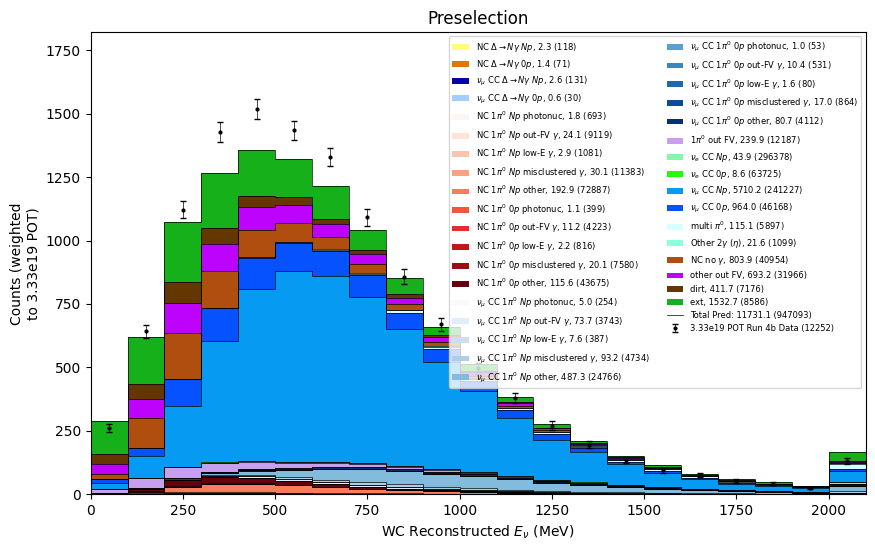

In [8]:
make_plot(pred_and_data_sel_df=presel_merged_df, bins=np.linspace(0, 2000, 21), var="wc_kine_reco_Enu", display_var=r"WC Reconstructed $E_\nu$ (MeV)", title="Preselection")


# BDT Score Plots

In [9]:
#for category in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "nueCC_Np", "nueCC_0p"]:
#    make_plot(presel_merged_df, bins=np.linspace(0, 1, 21), var=f"prob_{category}", title="Preselection", log_y=True)


# BDT Variable Plots

In [10]:
#pred_sel_df = presel_merged_df.filter(pl.col("filetype") != "data")
#data_sel_df = presel_merged_df.filter(pl.col("filetype") == "data")
#for var in pandora_scalar_second_half_training_vars:
#    make_plot(pred_sel_df=pred_sel_df, data_sel_df=data_sel_df, var=var, title="Preselection", breakdown_type="filetype", log_y=True)


# Topology Grid Histograms

In [11]:
custom_cut_values = [
    pl.col("prob_1gNp") > 0.3,
    pl.col("prob_1g0p") > 0.9,
    pl.col("prob_1gNp1mu") > 0.5, 
    pl.col("prob_1g0p1mu") > 0.2,
    pl.col("prob_1g_outFV") > 0.5,
    None, #pl.col("prob_NC1pi0_Np") > 0.5,
    None, #pl.col("prob_NC1pi0_0p") > 0.5,
    (pl.col("prob_numuCC1pi0_Np") > 0.3) & (pl.col("prob_numuCC1pi0_0p") < 0.1),
    pl.col("prob_numuCC1pi0_0p") > 0.1,
    pl.col("prob_1pi0_outFV") > 0.1,
    (pl.col("prob_nueCC_Np") > 0.05) & (pl.col("prob_nueCC_0p") < 0.05),
    pl.col("prob_nueCC_0p") > 0.05,
    pl.col("prob_numuCC_Np") > 0.5,
    pl.col("prob_numuCC_0p") > 0.5,
    pl.col("prob_multi_pi0") > 0.02,
    pl.col("prob_eta_other") > 0.01,
    None, #pl.col("prob_NC_no_gamma") > 0.5,
    None, #pl.col("prob_other_outFV_dirt") > 0.5,
    None, #pl.col("prob_ext") > 0.5,
]

reco_category_queries_possible_overlap = []
for i, custom_cut_value in enumerate(custom_cut_values):
    if custom_cut_value is None:
        reco_category_queries_possible_overlap.append(reco_category_argmax_queries[i])
    else:
        reco_category_queries_possible_overlap.append(custom_cut_value)

reco_category_queries = []
for i in range(len(reco_category_queries_possible_overlap)):
    curr_query = reco_category_queries_possible_overlap[i]
    for j in range(i):
        curr_query = curr_query & ~reco_category_queries_possible_overlap[j]

    reco_category_queries.append(curr_query)


  0%|          | 0/19 [00:00<?, ?it/s]

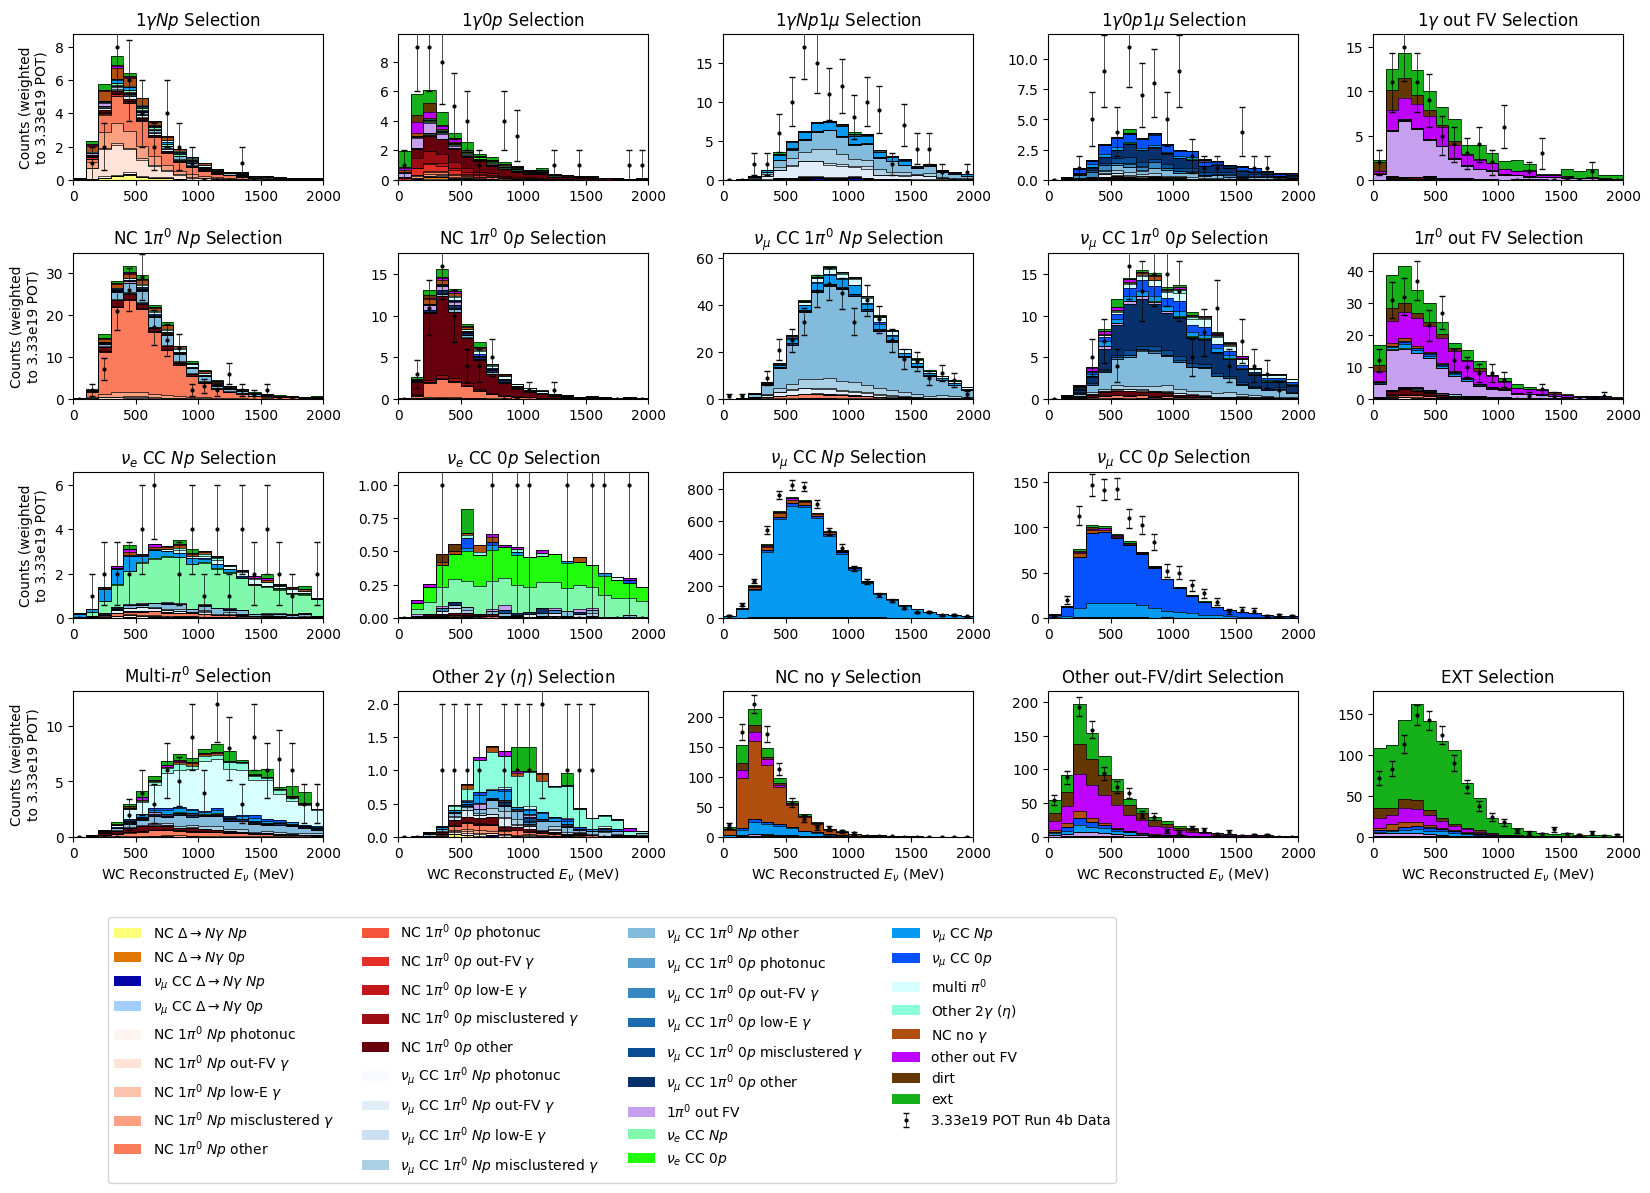

In [12]:
do_grid = True

iso1g_norm_factor = None
del1g_norm_factor = None

do_full_pred_grid = False
include_data = True

if do_grid:

    additional_scaling_factor = 1

    breakdown_queries = []
    for i in range(len(del1g_detailed_category_labels)):
        breakdown_queries.append(pl.col('del1g_detailed_signal_category') == i)
    breakdown_labels = del1g_detailed_category_labels
    breakdown_labels_latex = del1g_detailed_category_labels_latex
    breakdown_colors = del1g_detailed_category_colors
    breakdown_hatches = del1g_detailed_category_hatches

    if do_full_pred_grid:
        additional_scaling_factor = 1.11e21 / 3.33e19
        """breakdown_queries = []
        for i in range(len(del1g_simple_category_labels)):
            breakdown_queries.append(pl.col('del1g_simple_signal_category') == i)
        breakdown_labels = del1g_simple_category_labels
        breakdown_labels_latex = del1g_simple_category_labels_latex
        breakdown_colors = del1g_simple_category_colors
        breakdown_hatches = del1g_simple_category_hatches"""

    fig, axs = plt.subplots(7, 5, figsize=(20, 20))
    axs = axs.flatten()

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    for i in tqdm(range(len(reco_categories))):

        signal_category = reco_categories[i]
        signal_category_latex = reco_category_labels_latex[i]

        sel_df = presel_merged_df.filter(reco_category_queries[i])

        pred_sel_df = sel_df.filter(pl.col("filetype") != "data")
        data_sel_df = sel_df.filter(pl.col("filetype") == "data")

        breakdown_counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = pred_sel_df.filter(breakdown_queries[breakdown_i])
            breakdown_counts.append(np.histogram(curr_df.select("wc_kine_reco_Enu").to_numpy(), 
                                              weights=curr_df.select("wc_net_weight").to_numpy()*additional_scaling_factor, 
                                              bins=bins)[0])
        data_counts = np.histogram(data_sel_df.select("wc_kine_reco_Enu").to_numpy().flatten(), bins=bins)[0]

        axnum = i
        if i >= 14: # other background categories, start new row
            axnum = i + 1

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                if iso1g_norm_factor == None:
                    continue
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                if del1g_norm_factor == None:
                    continue
                breakdown_count = breakdown_count * del1g_norm_factor
            elif "data" in breakdown_label:
                continue

            n, _, _ = axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        #print(signal_category, np.sum(breakdown_counts))

        if include_data:
            axs[axnum].errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label="3.33e19 POT Run 4b Data")

        max_pred = np.max(bottom)
        max_data = np.max(data_counts)

        axs[axnum].set_ylim(0, max(max_pred, max_data) * 1.1)

        if axnum == 19:
            axs[axnum].legend(ncol=4, loc='upper right', bbox_to_anchor=(-1, -0.5))

        if axnum in [15, 16, 17, 18, 19]:
            axs[axnum].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        if axnum % 5 == 0: # Only show y-label for leftmost column
            if additional_scaling_factor != 1.0:
                axs[axnum].set_ylabel(f"Counts (weighted\nto {additional_scaling_factor*3.33e19:.2e} POT)")
            else:
                axs[axnum].set_ylabel("Counts (weighted\nto 3.33e19 POT)")
        axs[axnum].set_title(f"{signal_category_latex} Selection")
        axs[axnum].set_xlim(0, 2000)

    for axnum in range(len(axs)):
        if axnum in [14] or axnum > 19:
            axs[axnum].remove()

    fig.subplots_adjust(hspace=0.5, wspace=0.3, bottom=0.15)

    plt.savefig(f"../plots/multiclass_histograms_{training}.pdf")
    plt.savefig(f"../plots/multiclass_histograms_{training}.png")
    plt.show()


# One Shower Plots

## Multi-class BDT

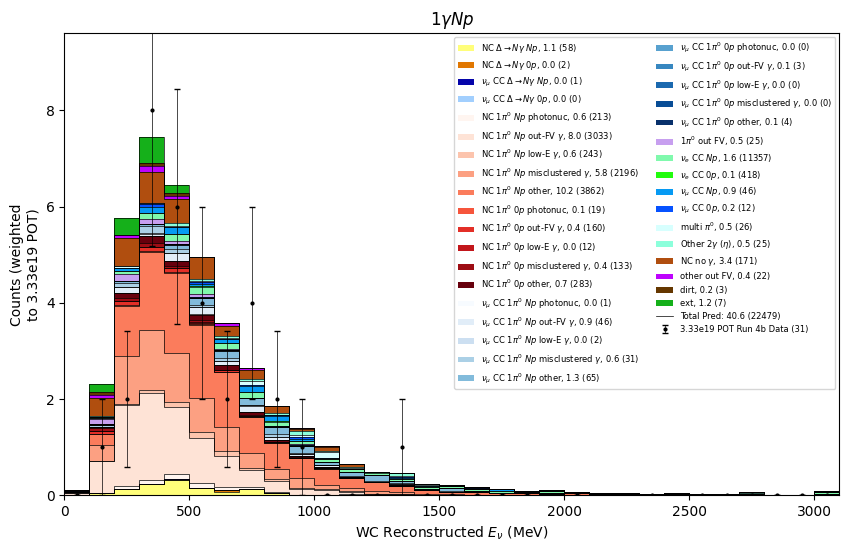

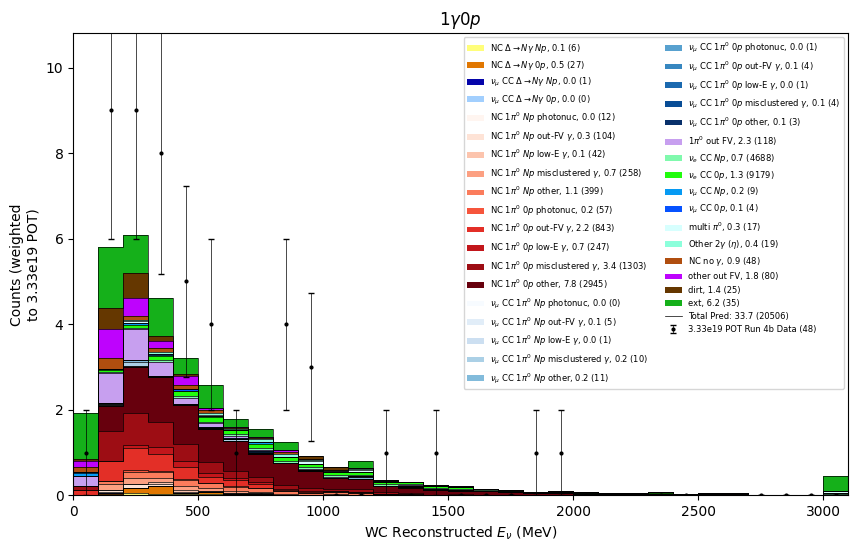

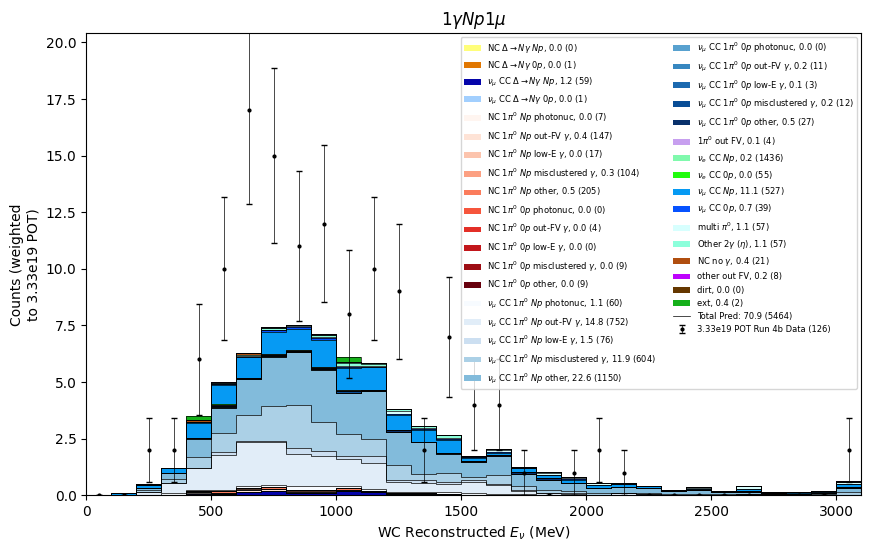

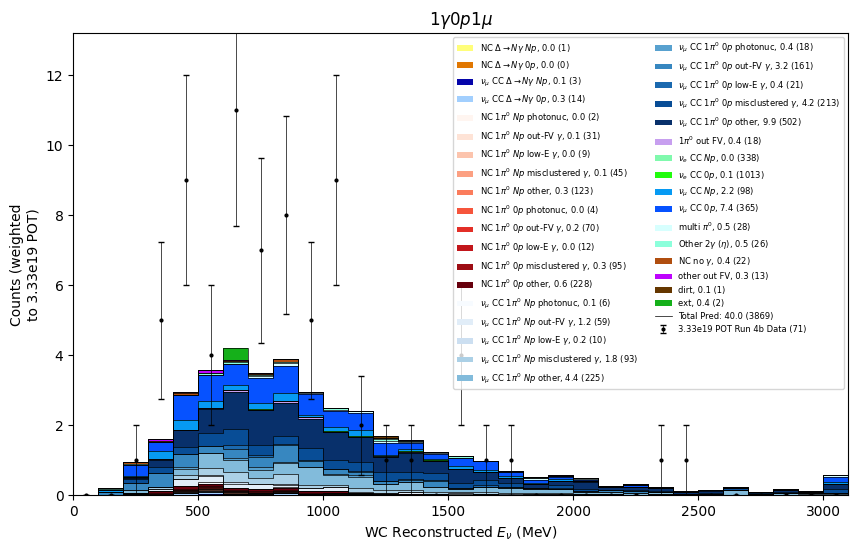

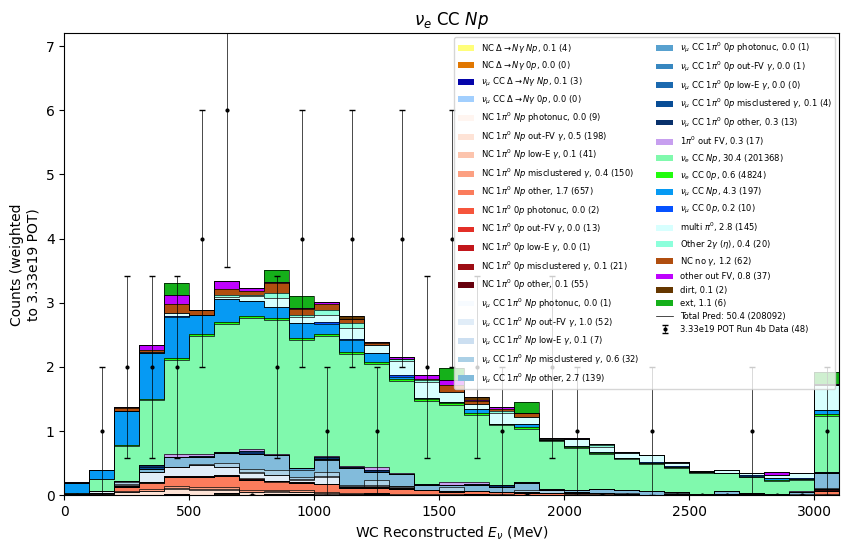

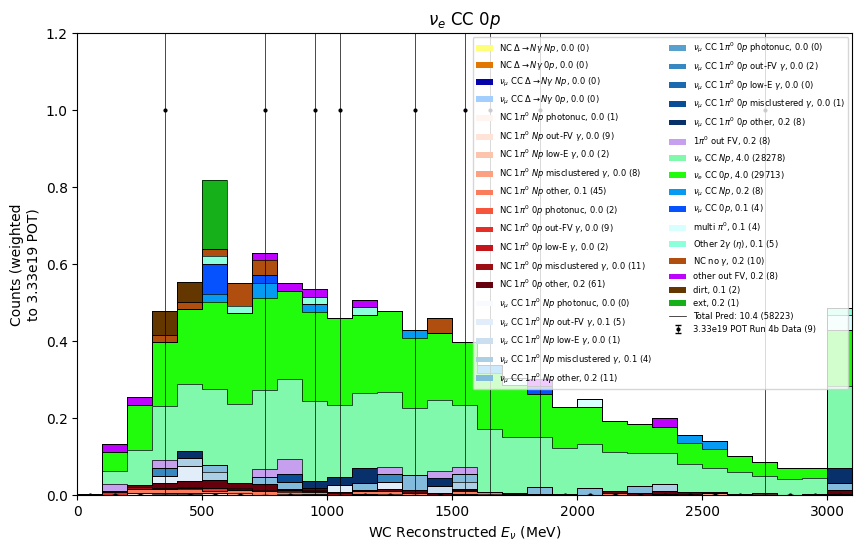

In [13]:
for reco_category in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "nueCC_Np", "nueCC_0p"]:
    reco_category_i = reco_categories.index(reco_category)
    reco_category_latex = reco_category_labels_latex[reco_category_i]

    sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])

    make_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(0, 3000, 31), var="wc_kine_reco_Enu", display_var=r"WC Reconstructed $E_\nu$ (MeV)", title=reco_category_latex)


## Older 1g selections

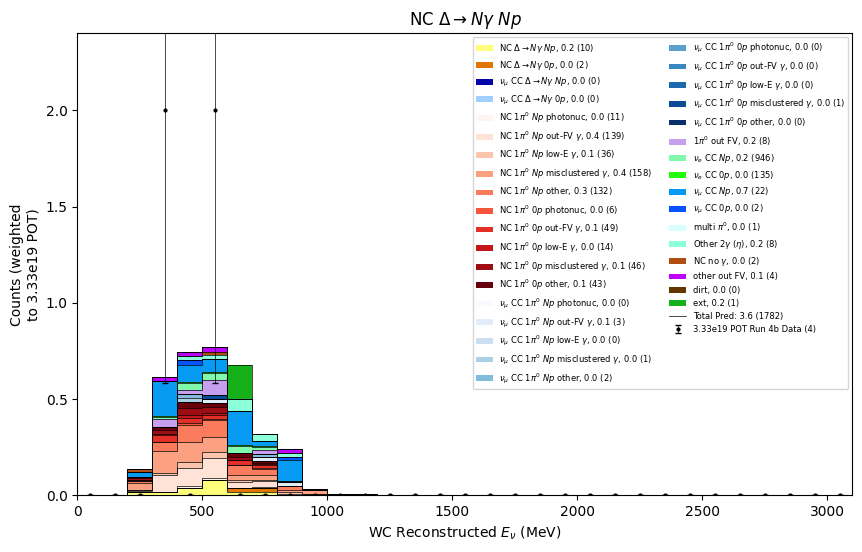

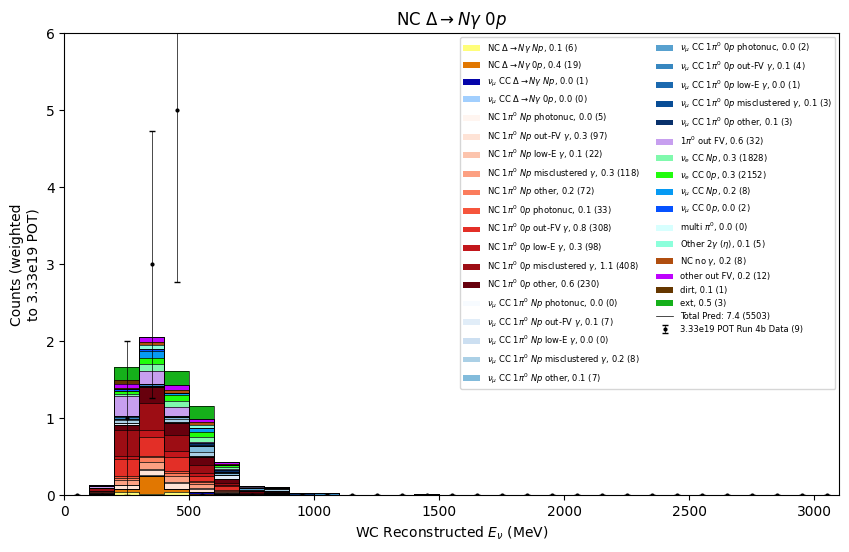

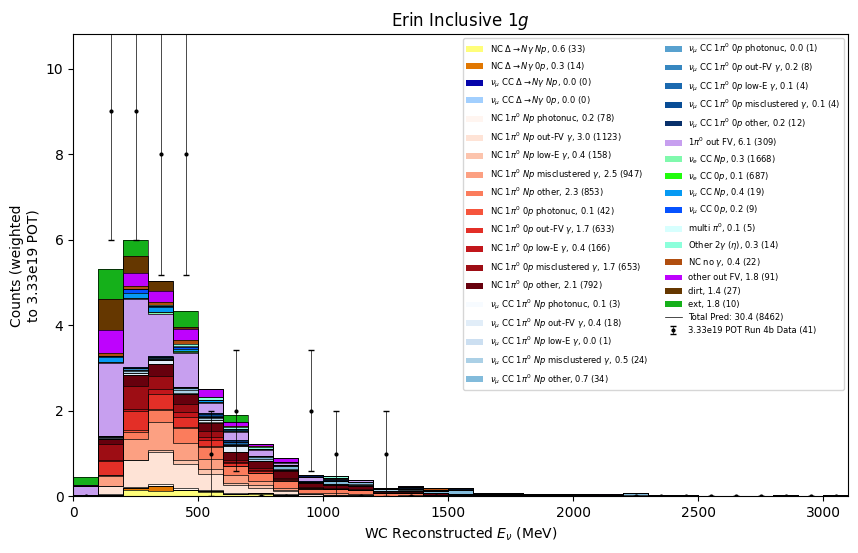

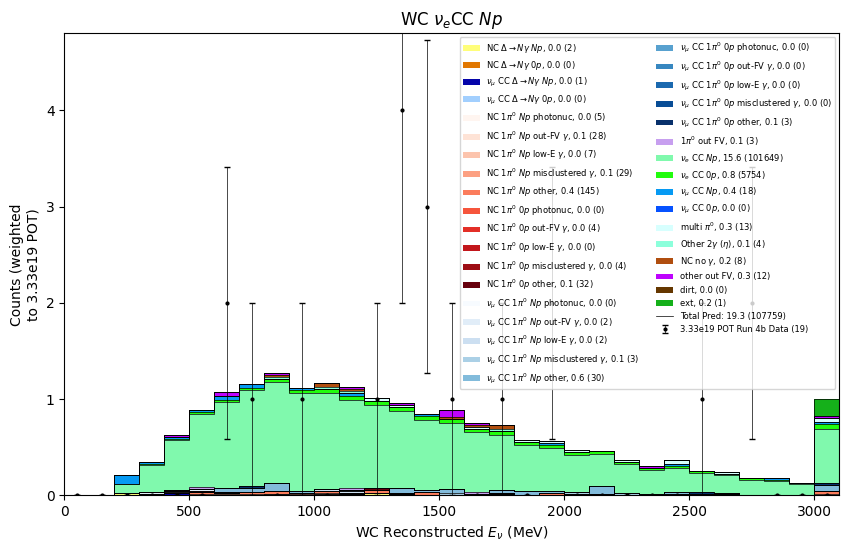

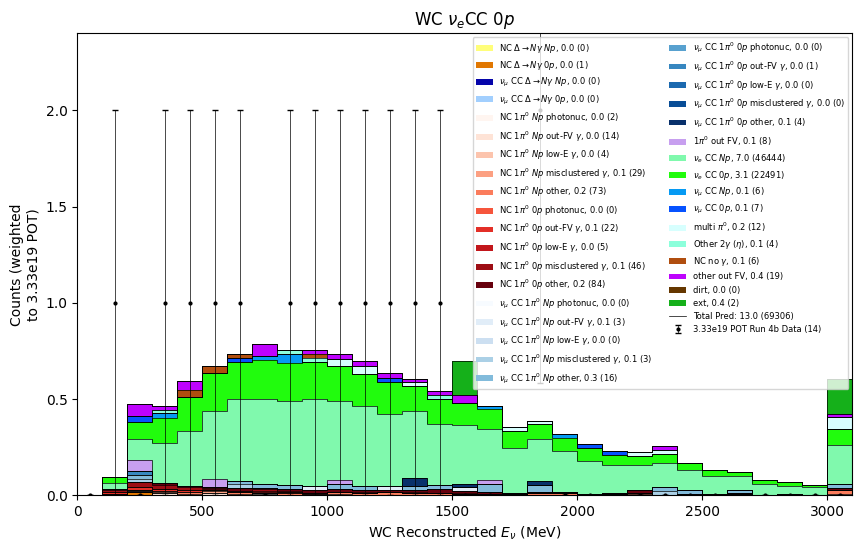

In [14]:
for reco_category in ["NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "erin_inclusive_1g", "WC_nueCC_Np", "WC_nueCC_0p"]:
    
    if reco_category == "presel":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category == "NCDeltaRad_1gNp":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_nc_delta_score") > 2.61) & 
            (pl.col("wc_reco_num_protons_35_MeV") > 0)
        )
        reco_category_latex = r"NC $\Delta\rightarrow N\gamma$ $Np$"
    elif reco_category == "NCDeltaRad_1g0p":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_nc_delta_score") > 2.61) & 
            (pl.col("wc_reco_num_protons_35_MeV") == 0)
        )
        reco_category_latex = r"NC $\Delta\rightarrow N\gamma$ $0p$"
    elif reco_category == "erin_inclusive_1g":
        sel_df = presel_merged_df.filter(pl.col("erin_inclusive_1g_sel") == 1)
        reco_category_latex = r"Erin Inclusive $1g$"
    elif reco_category == "WC_nueCC_Np":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_nue_score") > 7) & 
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_reco_num_protons_35_MeV") > 0)
        )
        reco_category_latex = r"WC $\nu_e$CC $Np$"
    elif reco_category == "WC_nueCC_0p":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_nue_score") > 7) & 
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_reco_num_protons_35_MeV") == 0)
        )
        reco_category_latex = r"WC $\nu_e$CC $0p$"
    
    make_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(0, 3000, 31), var="wc_kine_reco_Enu", display_var=r"WC Reconstructed $E_\nu$ (MeV)", title=reco_category_latex)


# Post-Selection Studies

## Backward Projected Distance

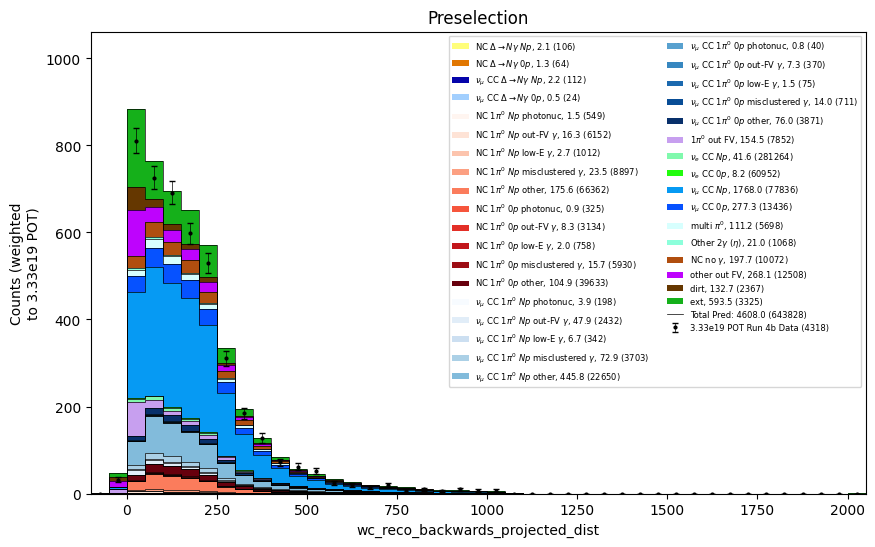

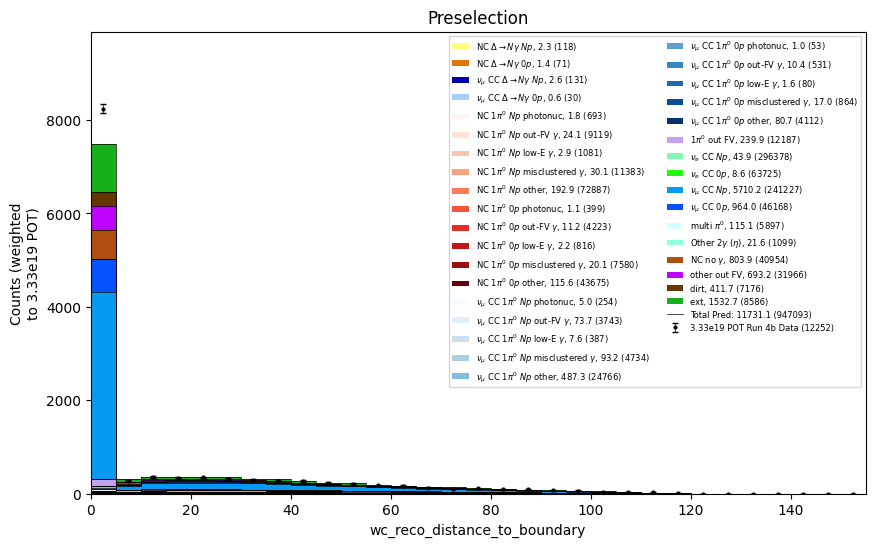

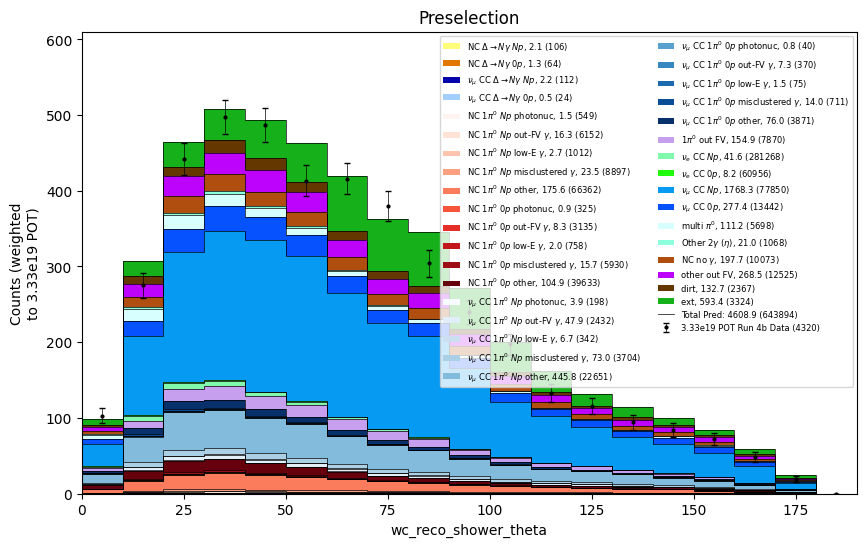

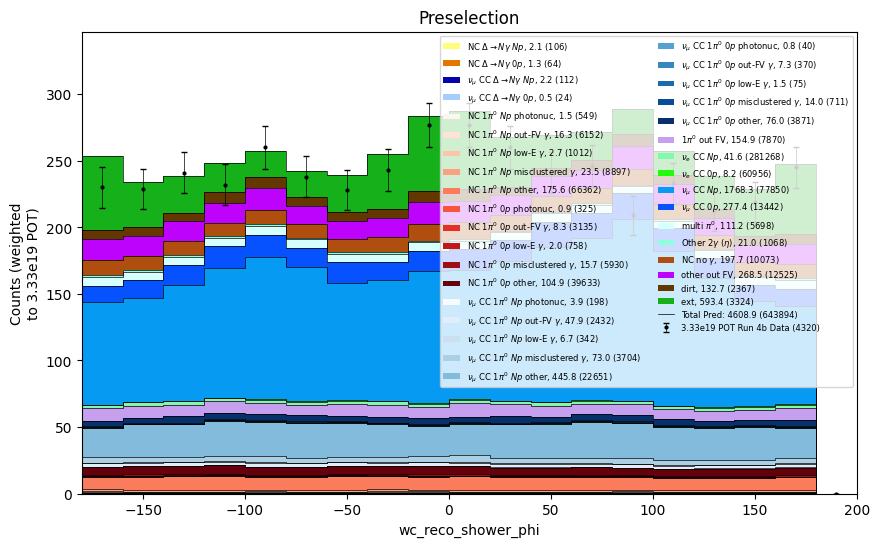

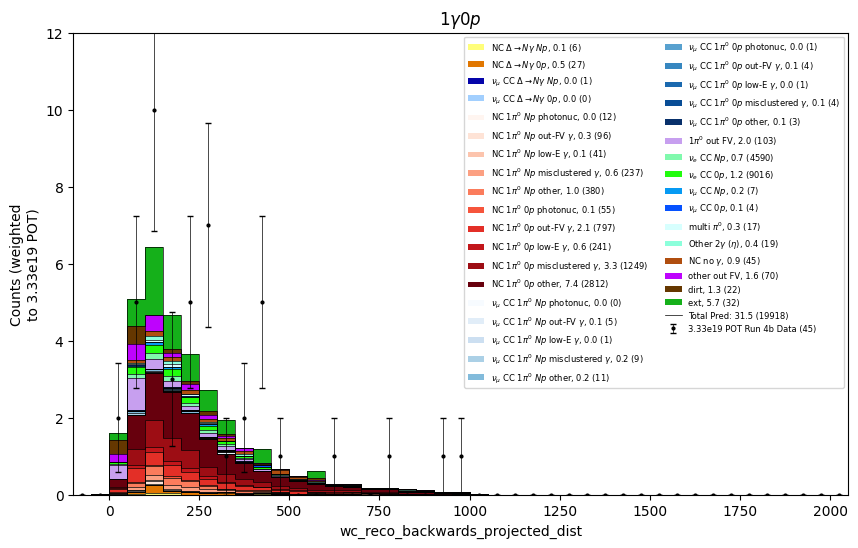

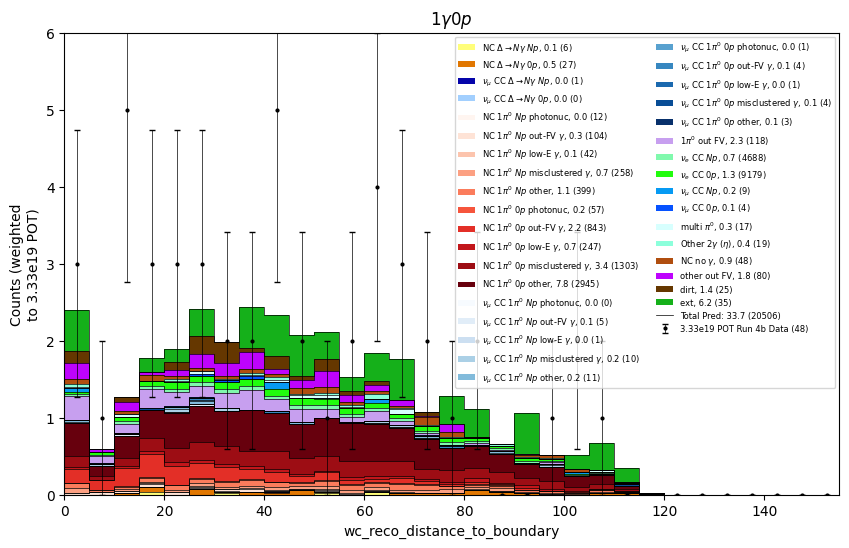

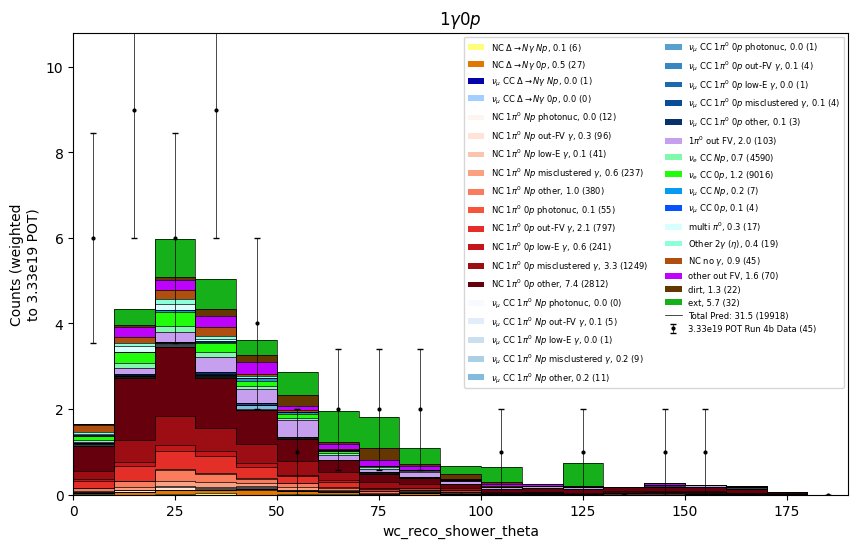

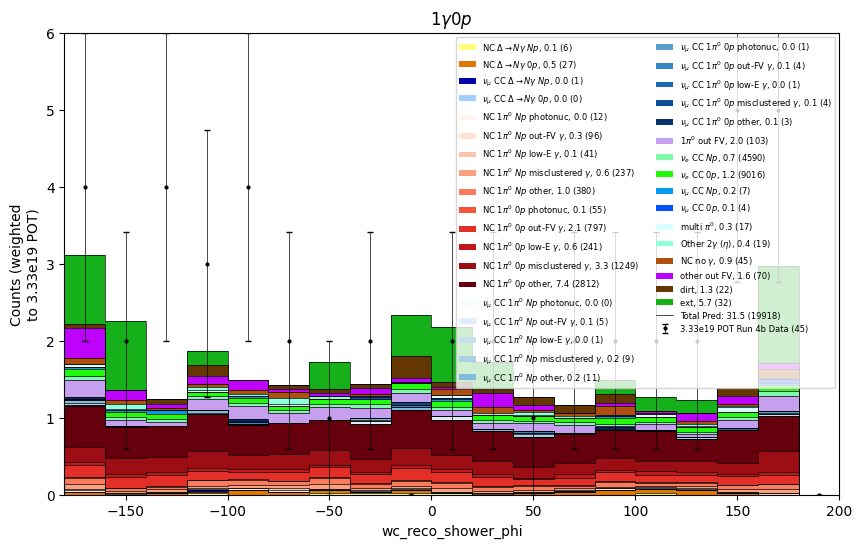

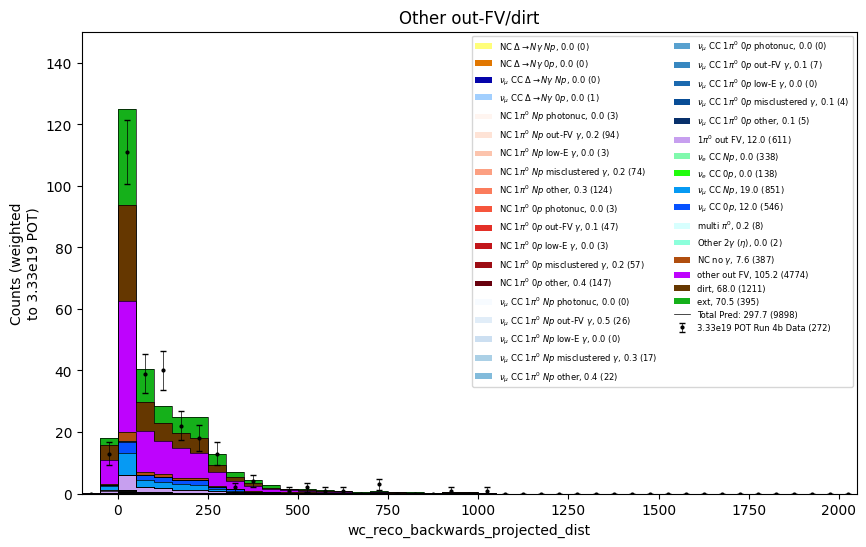

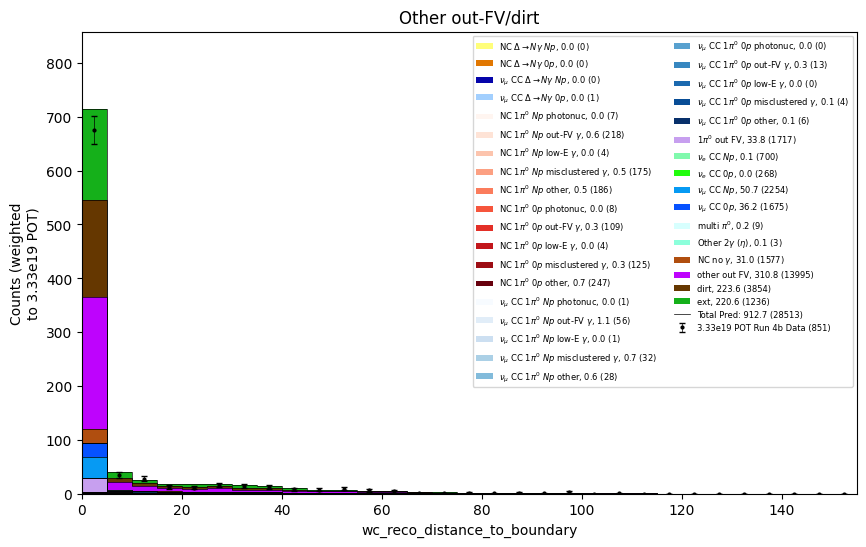

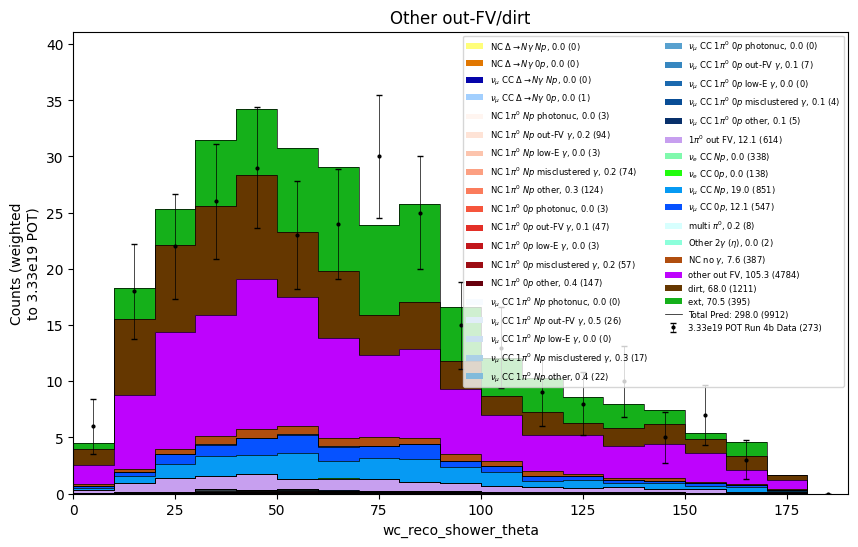

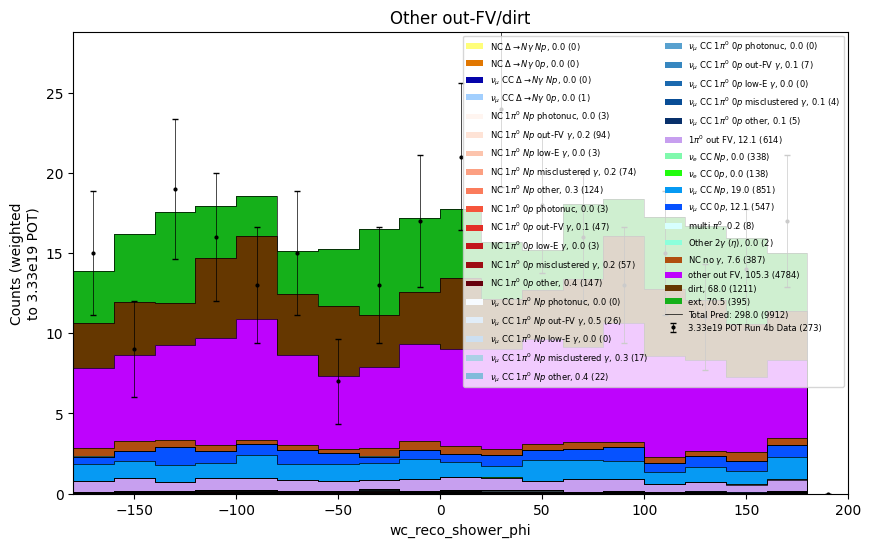

In [15]:
for reco_category in ["preselection", "1g0p", "other_outFV_dirt"]:

    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [
            ("wc_reco_backwards_projected_dist", np.linspace(-100, 2000, 43)),
            ("wc_reco_distance_to_boundary", np.linspace(0, 150, 31)), 
            ("wc_reco_shower_theta", np.linspace(0, 180, 19)),
            ("wc_reco_shower_phi", np.linspace(-180, 180, 19)),
        ]:

        make_plot(pred_and_data_sel_df=sel_df, bins=bins, var=var, display_var=var, title=reco_category_latex)

## Di-photon Invariant Mass

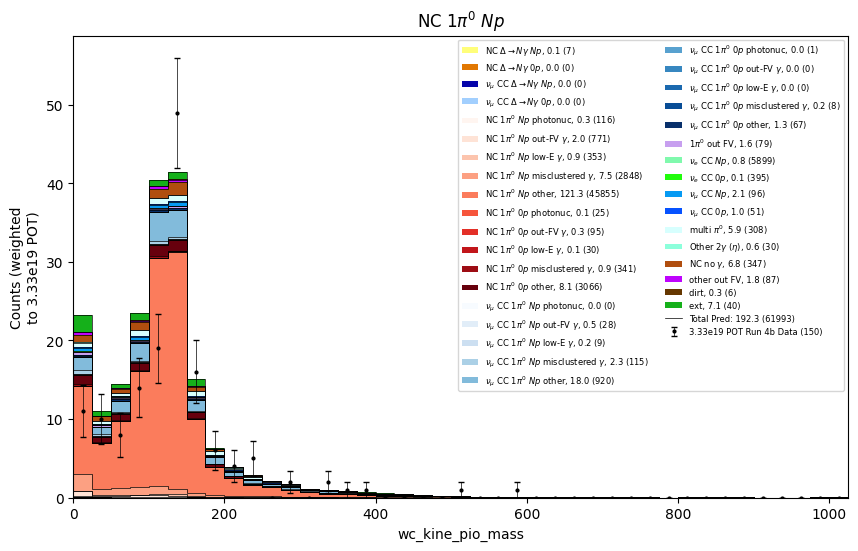

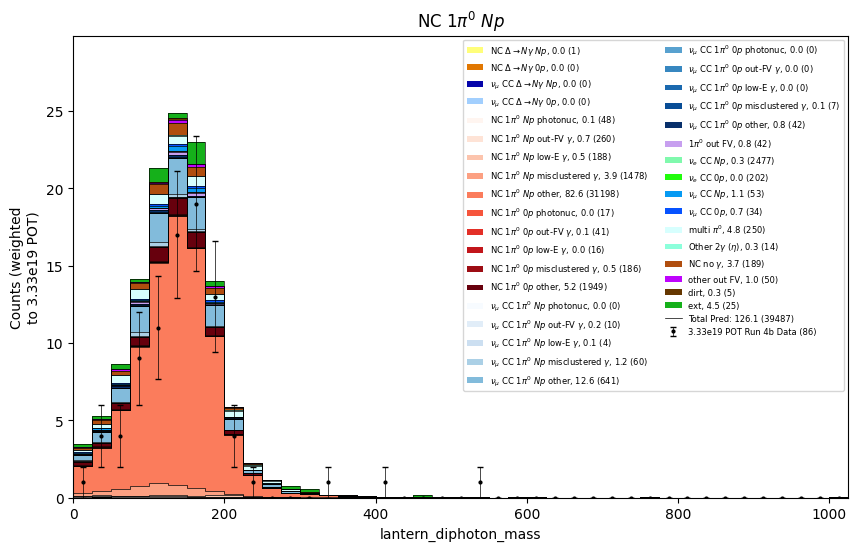

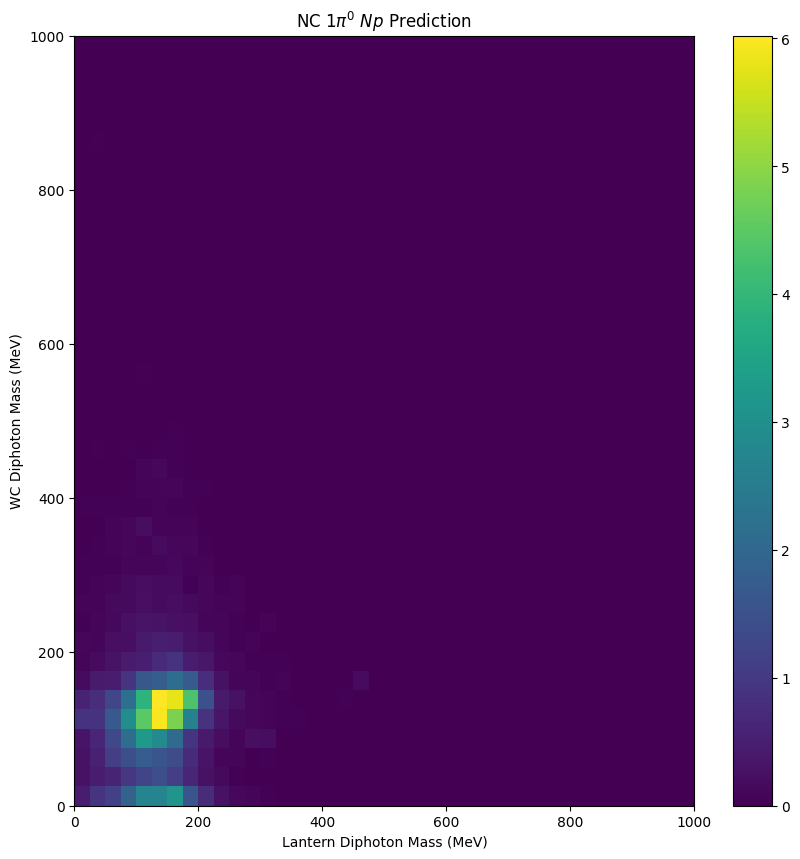

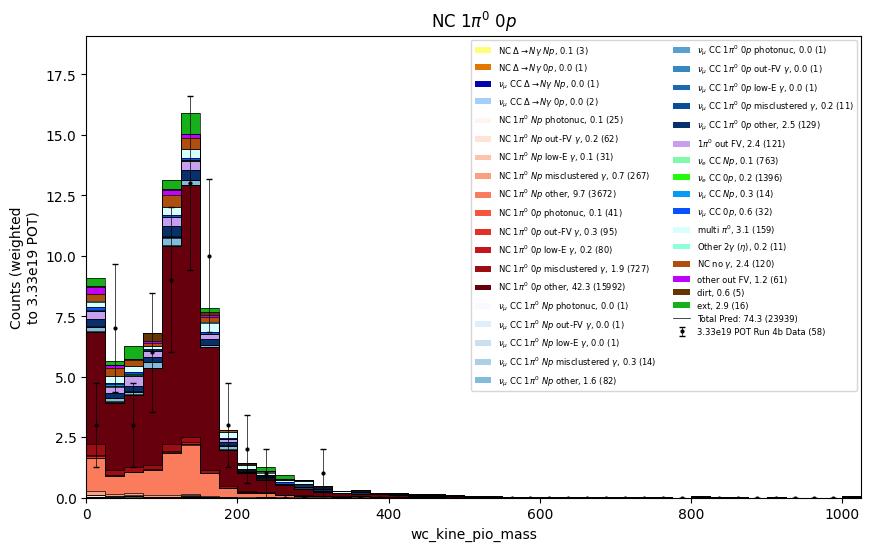

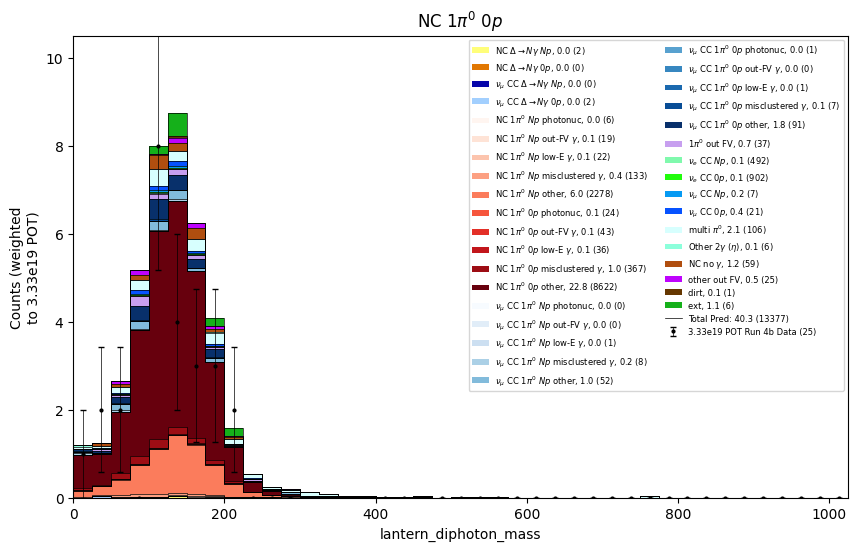

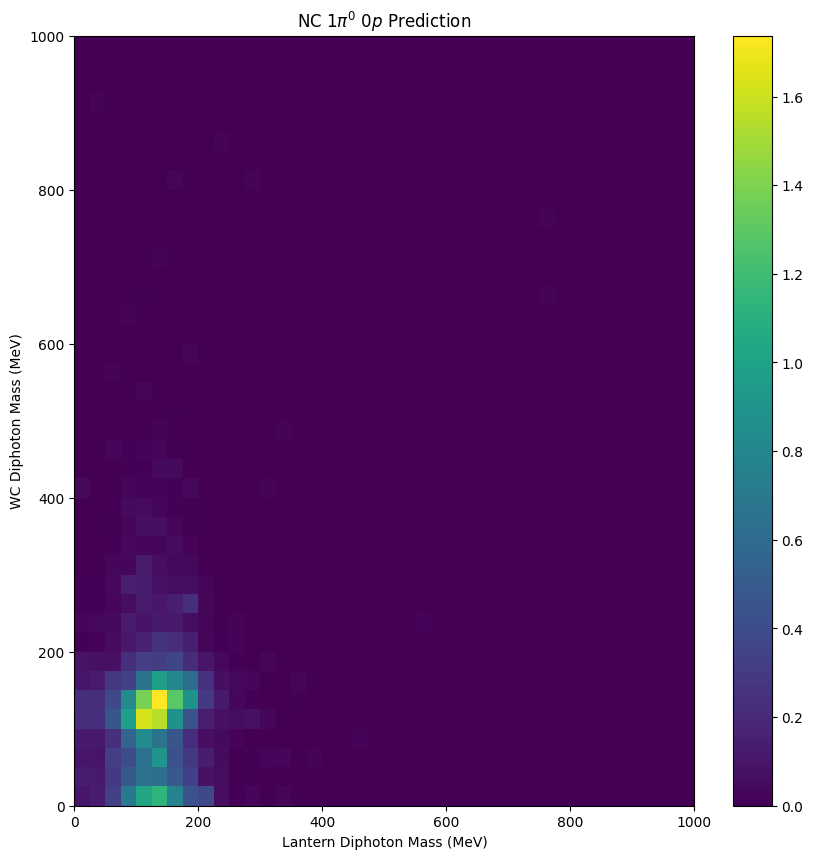

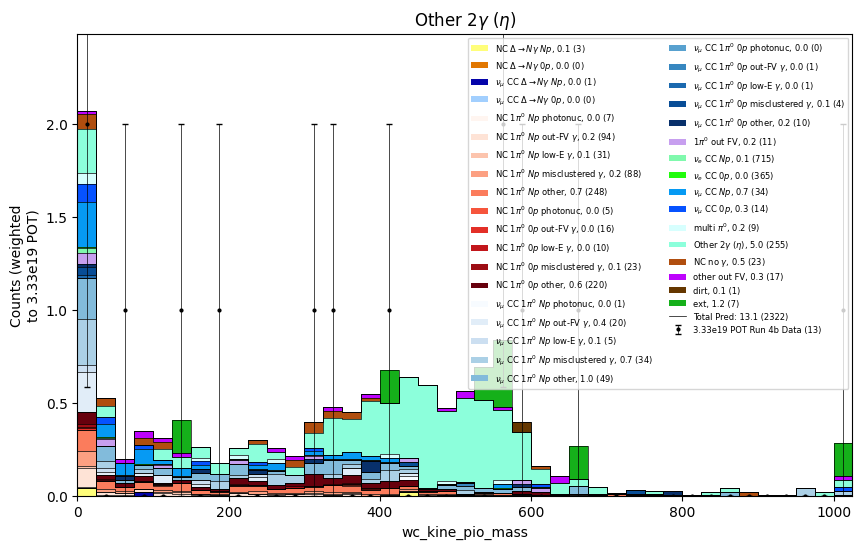

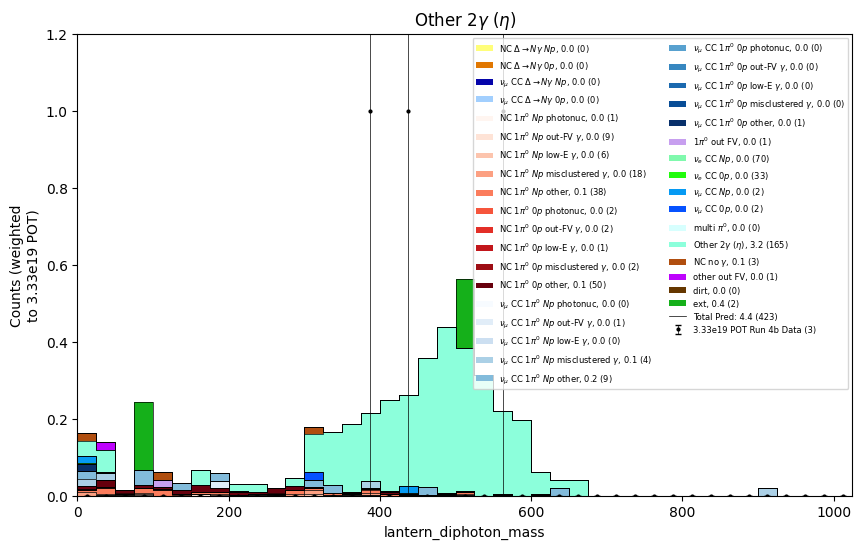

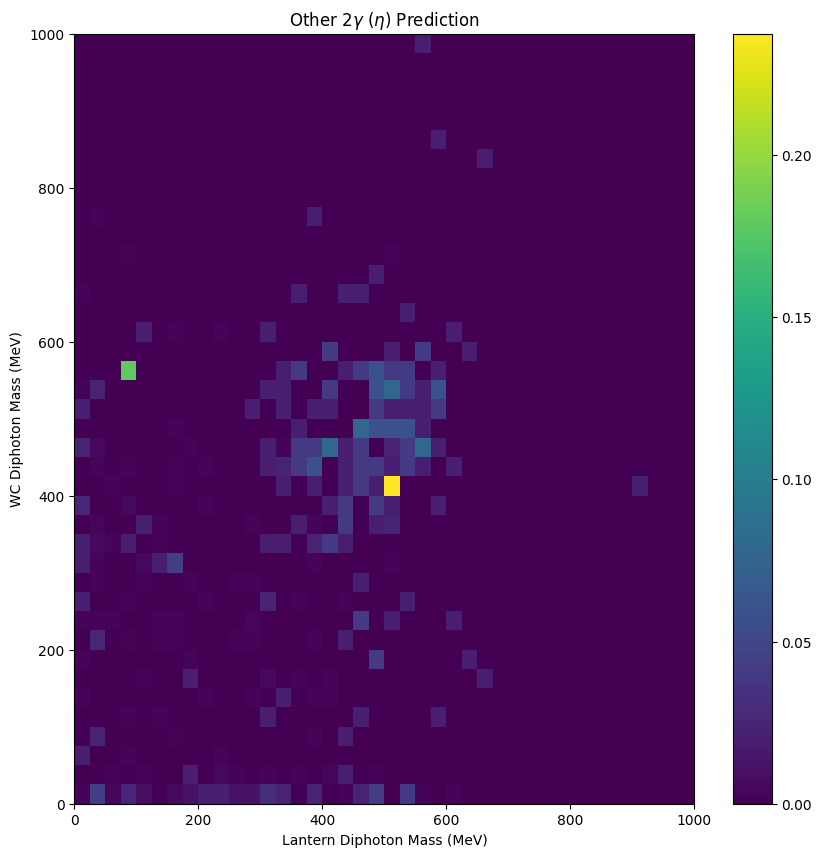

In [16]:
for reco_category in ["NC1pi0_Np", "NC1pi0_0p", "eta_other"]:
    if reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        pred_sel_df = sel_df.filter(pl.col("filetype") != "data")
        data_sel_df = sel_df.filter(pl.col("filetype") == "data")
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [
            ("wc_kine_pio_mass", np.linspace(0, 1000, 41)),
            ("lantern_diphoton_mass", np.linspace(0, 1000, 41)), 
            #("wc_kine_pio_angle", np.linspace(0, 180, 19)),
            #("lantern_diphoton_opening_angle", np.linspace(0, 180, 19)),
            #("wc_kine_pio_energy_1", np.linspace(0, 1000, 21)),
            #("lantern_diphoton_energy", np.linspace(0, 100000, 21)),
        ]:

        make_plot(pred_sel_df=pred_sel_df, data_sel_df=data_sel_df, bins=bins, var=var, display_var=var, title=reco_category_latex)

    plt.figure(figsize=(10, 10))
    plt.hist2d(pred_sel_df.select("lantern_diphoton_mass").to_numpy().flatten(), pred_sel_df.select("wc_kine_pio_mass").to_numpy().flatten(), 
                    weights=pred_sel_df.select("wc_net_weight").to_numpy().flatten(), 
                    bins=np.linspace(0, 1000, 41))
    plt.colorbar()
    plt.xlabel("Lantern Diphoton Mass (MeV)")
    plt.ylabel("WC Diphoton Mass (MeV)")
    plt.title(reco_category_latex + " Prediction")
    plt.show()
    

## Blips

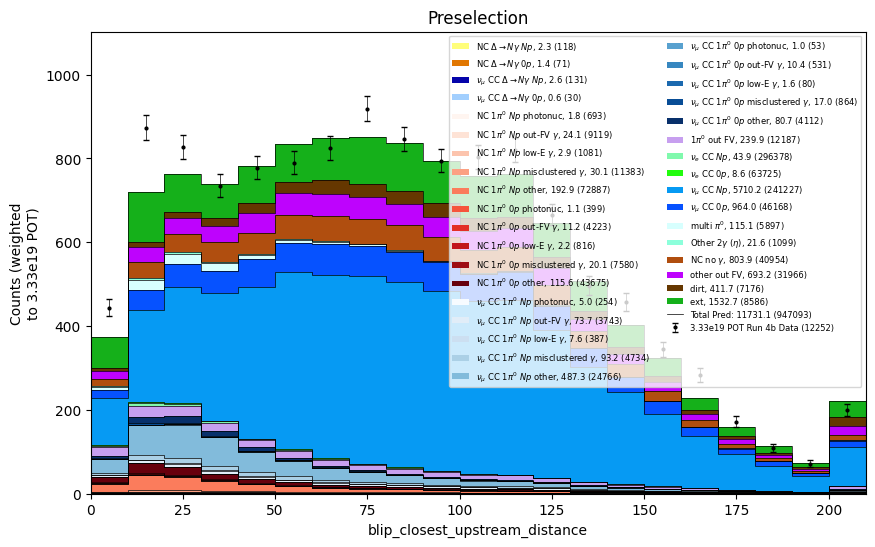

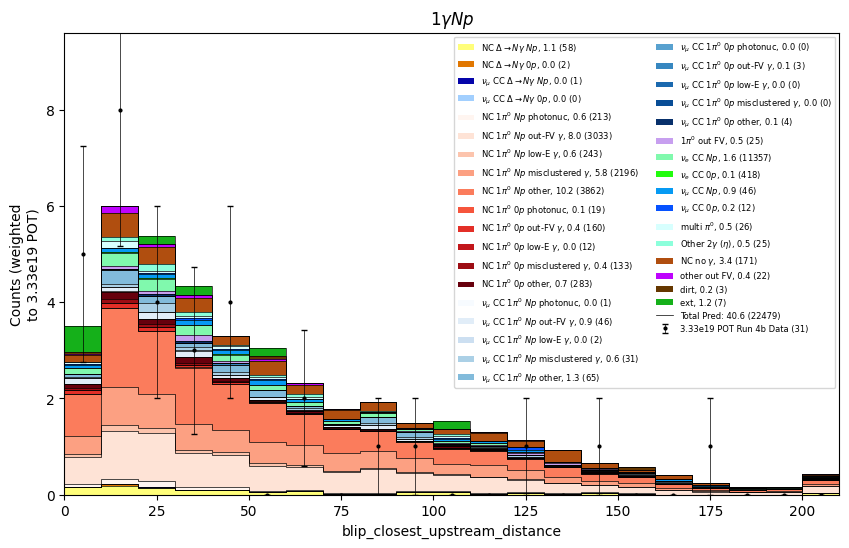

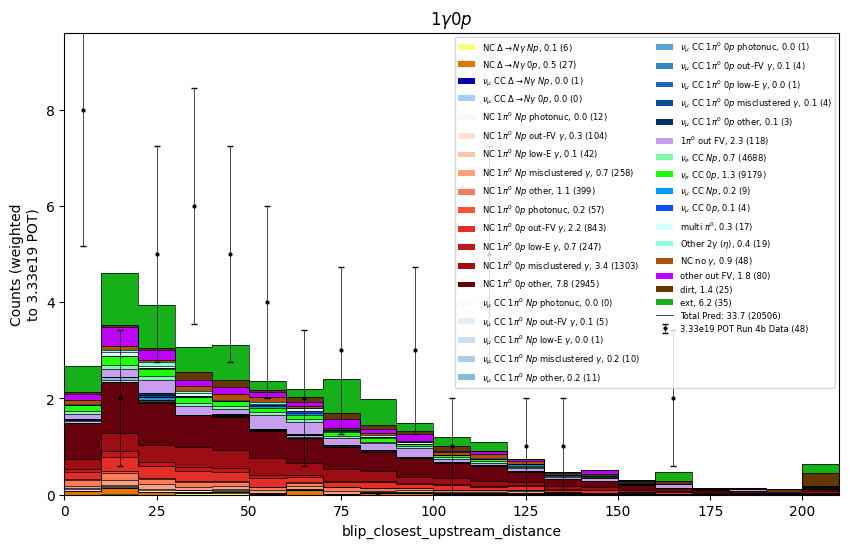

In [17]:
for reco_category in ["preselection", "1gNp", "1g0p"]:
    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [
            ("blip_closest_upstream_distance", np.linspace(0, 200, 21)),
            #("blip_closest_upstream_angle", np.linspace(0, 90, 19)),
            #("blip_closest_upstream_impact_parameter", np.linspace(0, 200, 21)),
            #("blip_closest_upstream_energy", np.linspace(0, 20, 21)),
            #("blip_closest_upstream_dx", np.linspace(0, 5, 11)),
        ]:

        make_plot(pred_and_data_sel_df=sel_df, bins=bins, var=var, display_var=var, title=reco_category_latex)
    

## Nanosecond Timing

In [18]:
# related to https://github.com/brb-rightback/ns_demo_MCC9.10/blob/main/ns_demo_MCC9.10.ipynb
# TODO: Validate this with data and showers, see https://microboone-docdb.fnal.gov/cgi-bin/sso/ShowDocument?docid=44781
# Also check the manually applied shifts for all the different time periods

beamon_presel_merged_df = presel_merged_df.filter(pl.col("filetype") == "data")
beamoff_presel_merged_df = presel_merged_df.filter(pl.col("filetype") == "ext") 
mc_presel_merged_df = presel_merged_df.filter(~pl.col("filetype").is_in(["data", "ext"]))

beamoff_presel_merged_df = beamoff_presel_merged_df.with_columns(pl.col("wc_evtTimeNS").alias("non_merge_time"))
beamon_presel_merged_df = beamon_presel_merged_df.with_columns((pl.col("wc_evtTimeNS") + 5700).alias("non_merge_time"))
mc_presel_merged_df = mc_presel_merged_df.with_columns((pl.col("wc_evtTimeNS_cor") + 1500).alias("non_merge_time")) # manually shifting MC to approximately match data

data_presel_merged_df = pl.concat([beamoff_presel_merged_df, beamon_presel_merged_df])
del beamoff_presel_merged_df
del beamon_presel_merged_df

def calc_merge_time_data(run, evt_time):
    gap = 18.936
    if run >= 19500:
        shift = 2920.5
    elif run >= 17380:
        shift = 2916.0
    elif run >= 13697:
        shift = 3147.3
    elif run >= 10812:
        shift = 3568.5
    elif run >= 8321:
        shift = 3610.7
    elif run >= 5800:
        shift = 3164.4
    else:
        shift = 3168.9
        
    tt_help = evt_time - shift + gap * 0.5
    if np.isinf(tt_help):
        tt_help = float('nan')
    
    if tt_help >= 0:
        return (tt_help - (int(tt_help/gap) * gap)) - gap * 0.5
    return -9999.

data_presel_merged_df = data_presel_merged_df.with_columns(
    pl.struct(["run", "wc_evtTimeNS"]).map_elements(lambda x: calc_merge_time_data(x["run"], x["wc_evtTimeNS"])).alias("merge_time")
)

def calc_merge_time_mc(evt_time):
    gap = 18.936
    shift = 5.8 - 0.3
    
    tt_help = np.nan_to_num(evt_time - shift + gap * 0.5, nan=-9999)
    
    if tt_help >= 0:
        return (tt_help - (int(tt_help/gap) * gap)) - gap * 0.5
    return -9999.

mc_presel_merged_df = mc_presel_merged_df.with_columns(
    pl.col("wc_evtTimeNS_cor").map_elements(calc_merge_time_mc).alias("merge_time")
)

presel_merged_df = pl.concat([mc_presel_merged_df, data_presel_merged_df])
del mc_presel_merged_df
del data_presel_merged_df


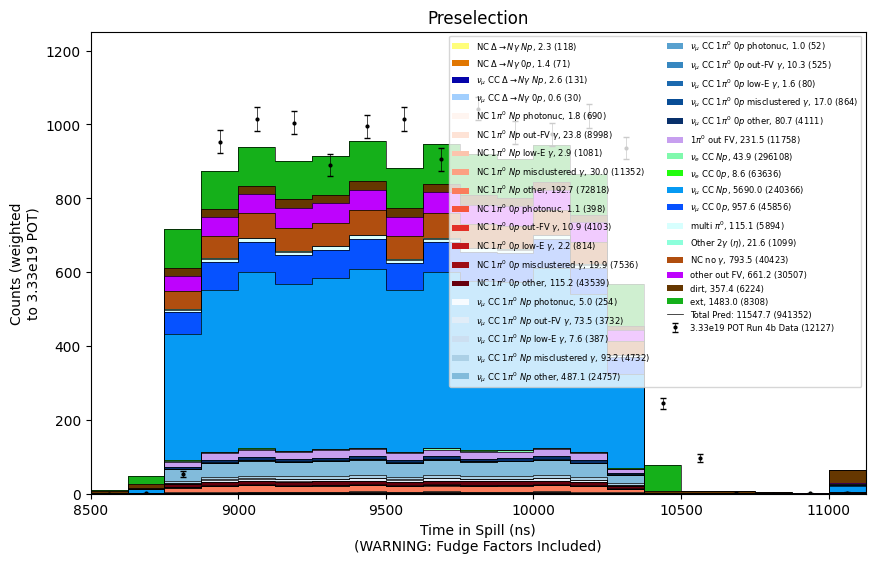

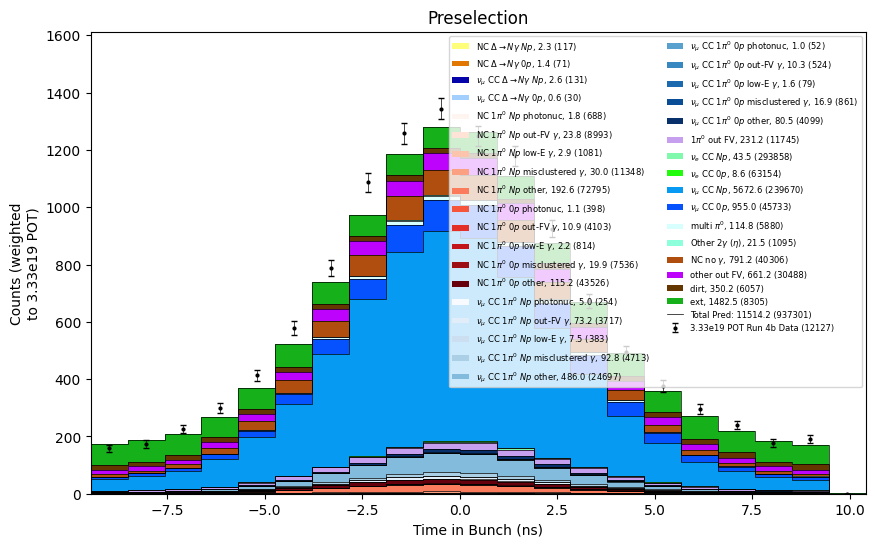

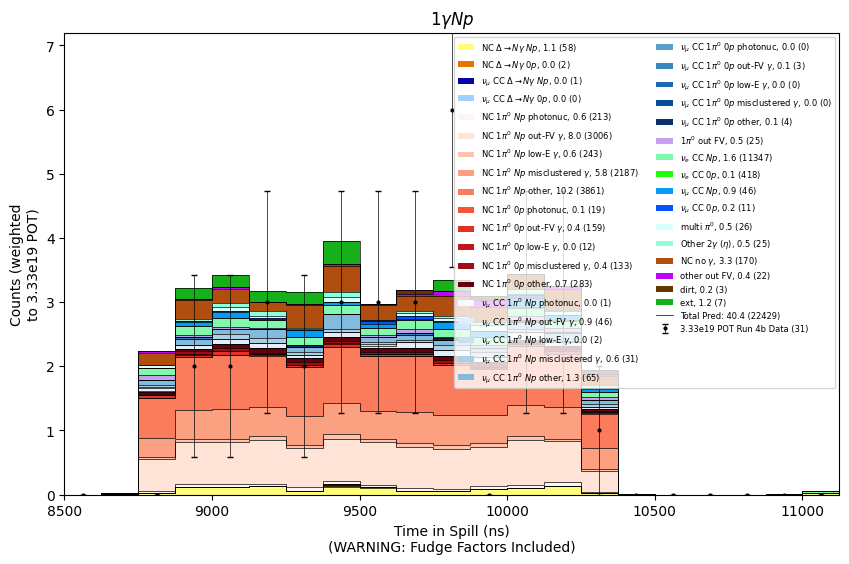

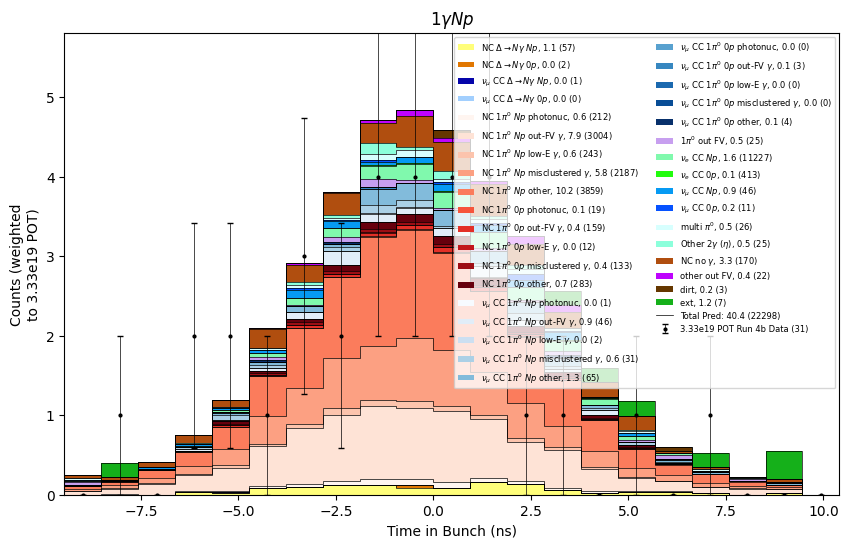

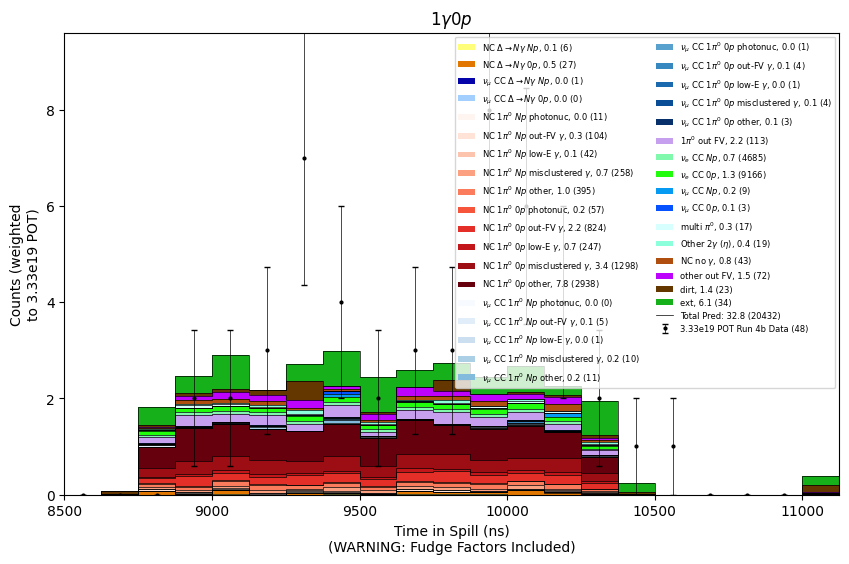

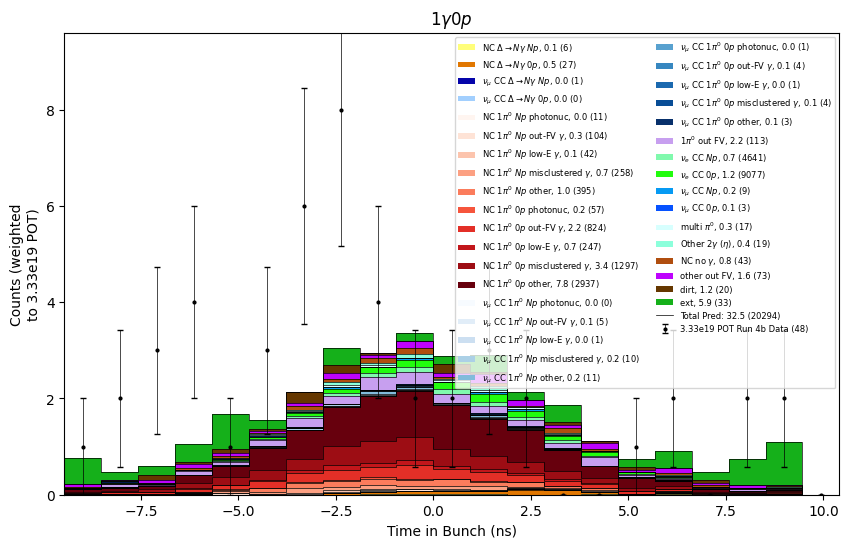

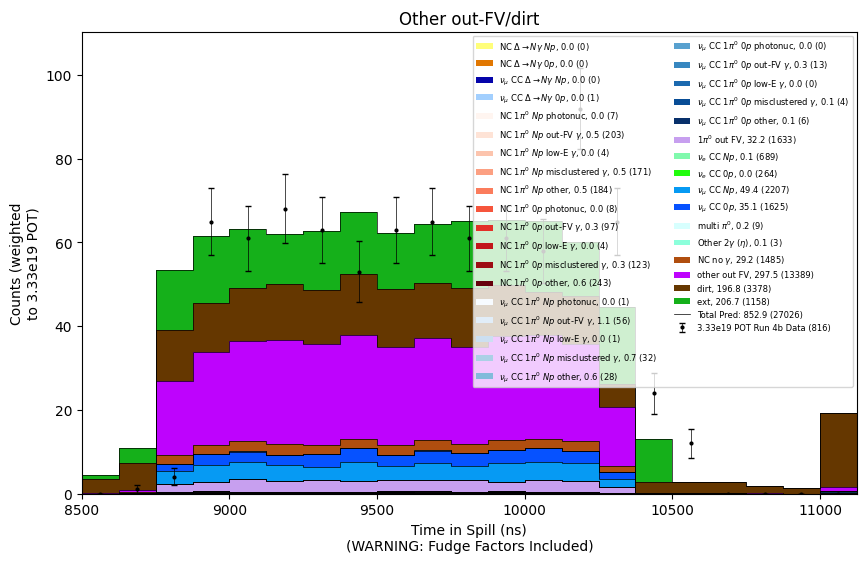

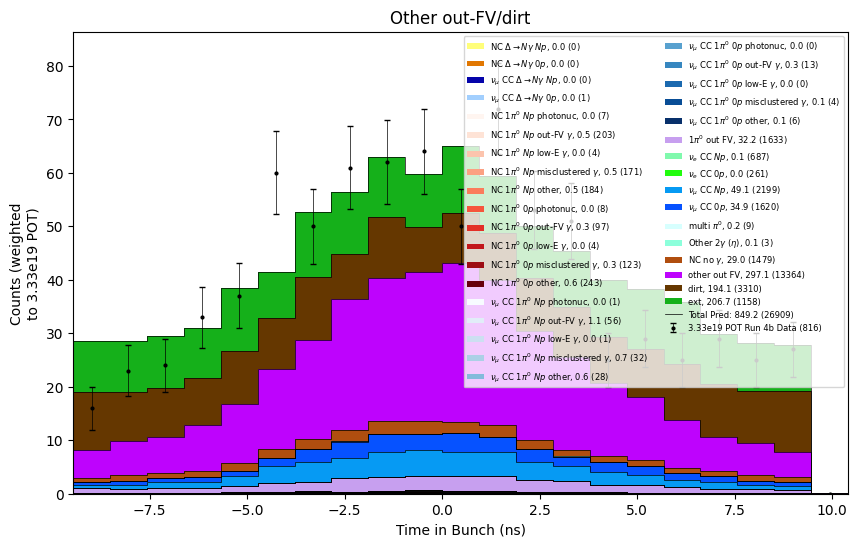

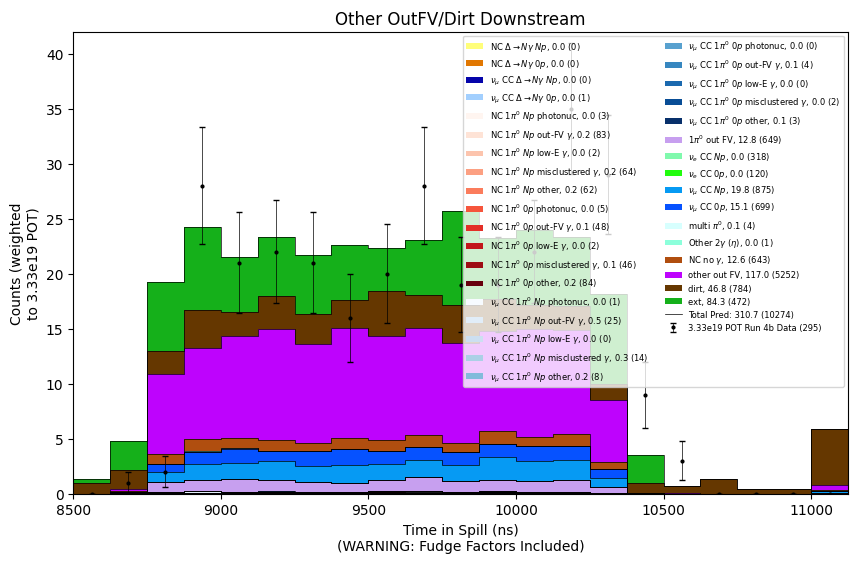

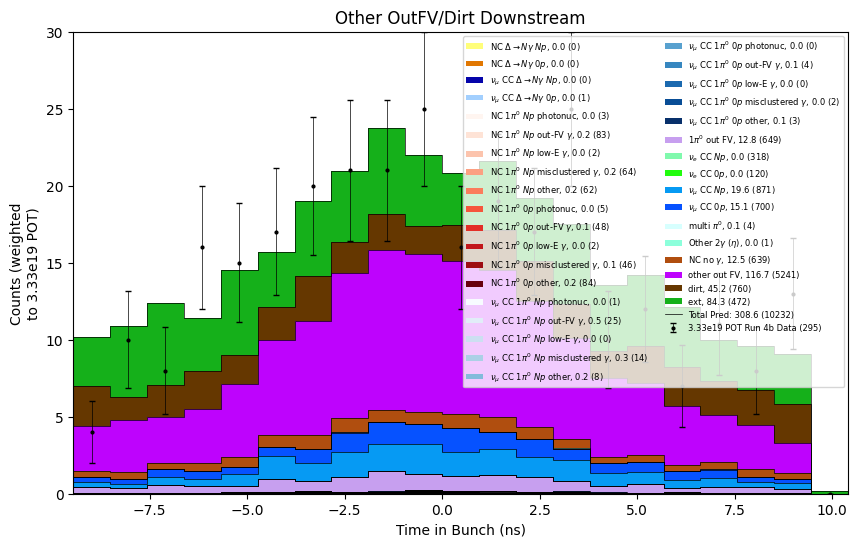

In [19]:
for reco_category in ["preselection", "1gNp", "1g0p", "other_outFV_dirt", "other_outFV_dirt_downstream"]:
    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    elif reco_category == "other_outFV_dirt_downstream":
        reco_category_i = reco_categories.index("other_outFV_dirt")
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i]).filter(pl.col("wc_reco_nuvtxZ") > 500)
        reco_category_latex = r"Other OutFV/Dirt Downstream"
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    make_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(8500, 11000, 21), var="non_merge_time", display_var="Time in Spill (ns)\n(WARNING: Fudge Factors Included)", title=reco_category_latex)
    make_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(-9.462531250000058, 9.462531250000058, 21), var="merge_time", display_var="Time in Bunch (ns)", title=reco_category_latex)


## Out-TPC PMT Veto

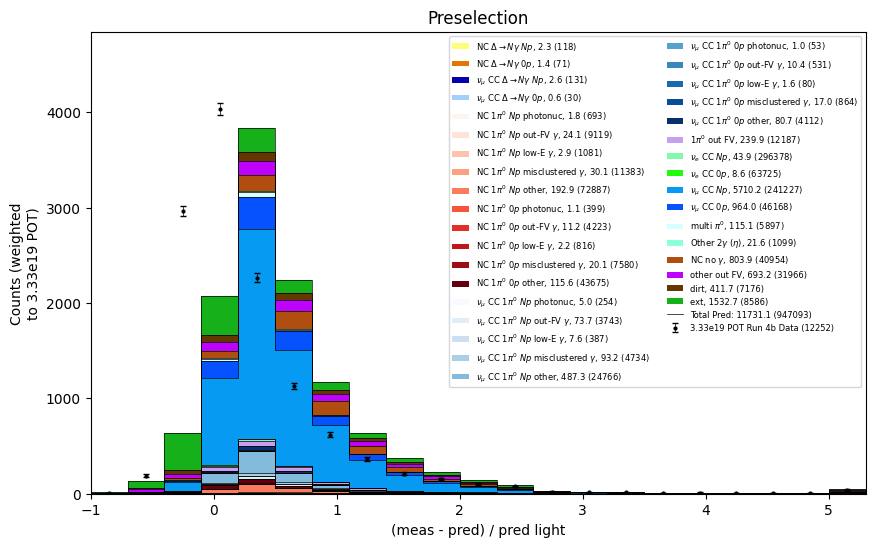

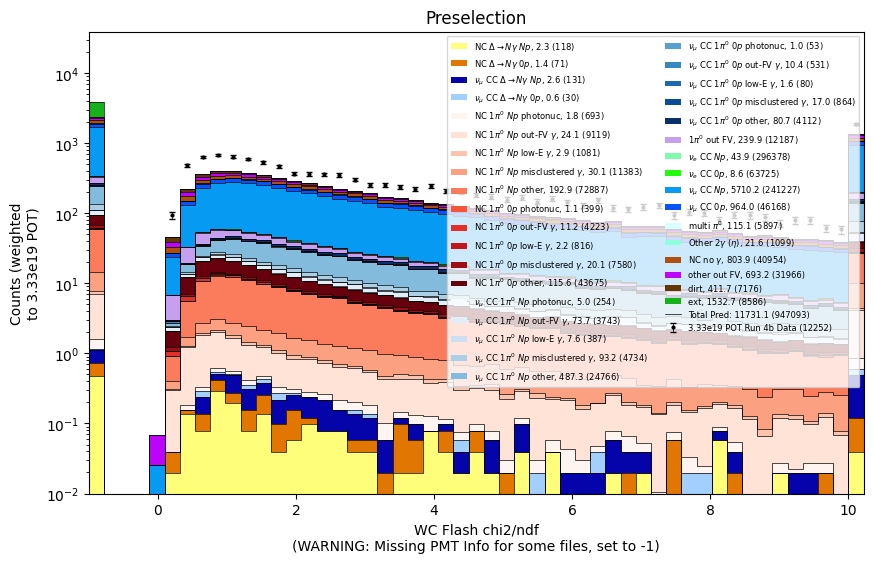

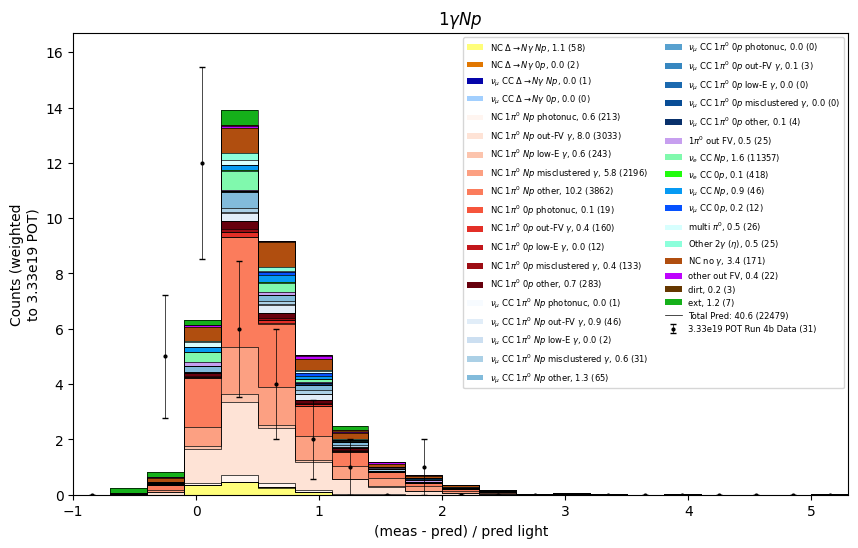

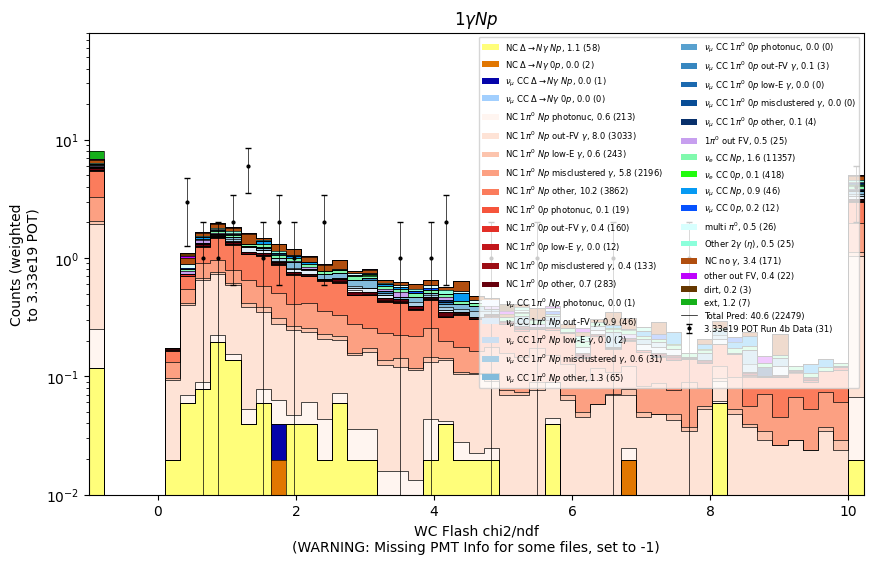

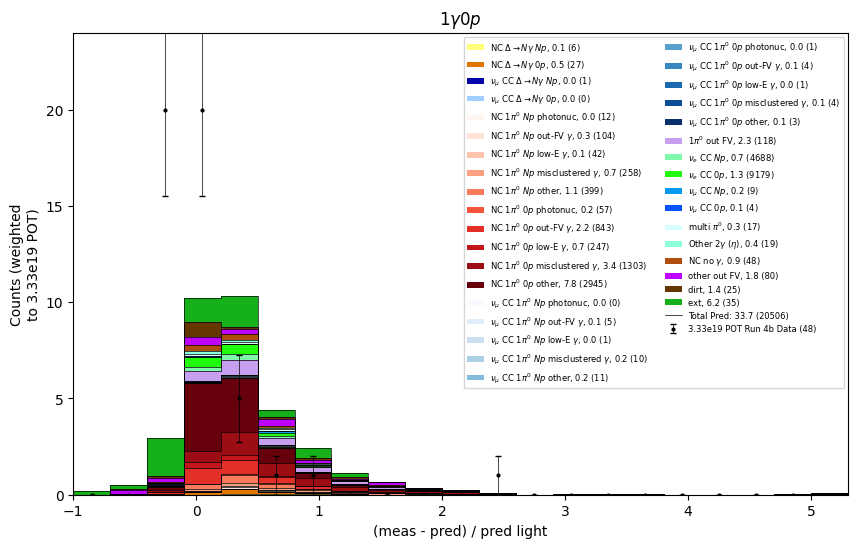

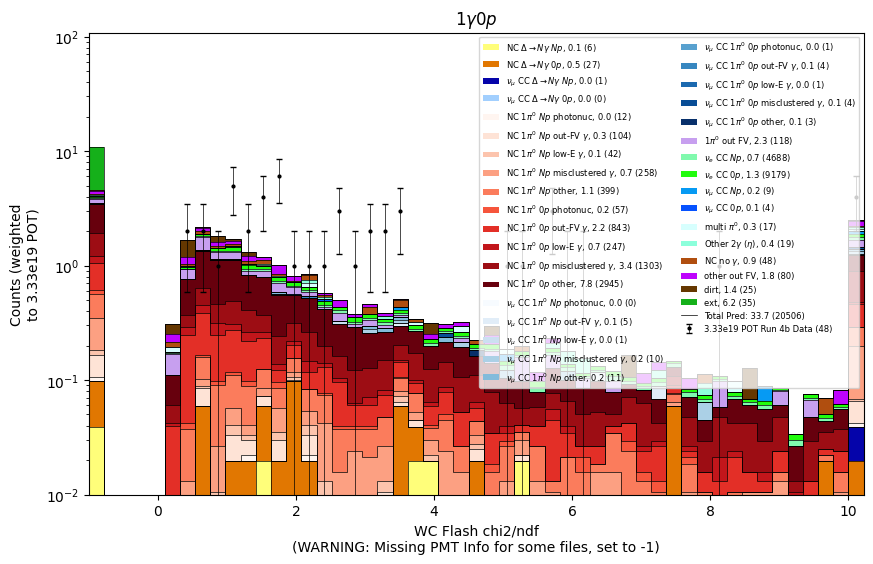

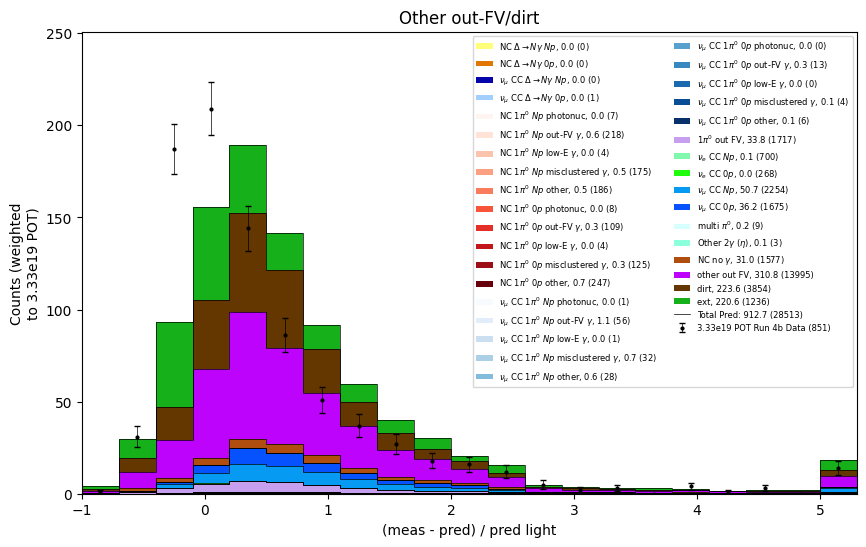

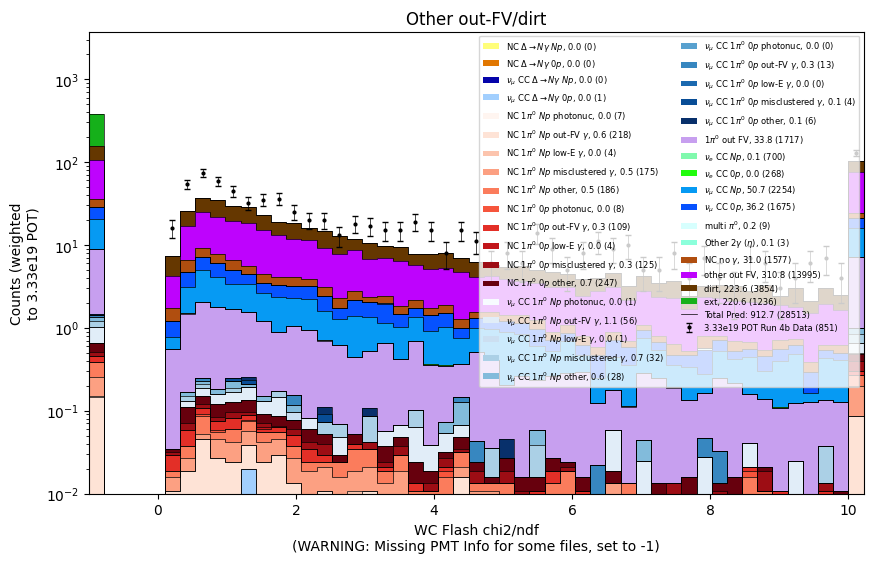

In [20]:
for reco_category in ["preselection", "1gNp", "1g0p", "other_outFV_dirt"]:

    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    make_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(-1, 5, 21), var="(wc_flash_measPe - wc_flash_predPe) / wc_flash_predPe", display_var="(meas - pred) / pred light", title=reco_category_latex)
    make_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(-1, 10, 51), var="wc_WCPMTInfoChi2 / wc_WCPMTInfoNDF", display_var="WC Flash chi2/ndf\n(WARNING: Missing PMT Info for some files, set to -1)", title=reco_category_latex, log_y=True)


## Out-TPC CRT Veto

In [21]:
# TODO: Look at CRT information, and if we can identify in-time out-TPC activity associated with an event
# (even if there's no clean CRT track indicating a through-going cosmic muon)


# Out-TPC Geometric BDT

In [22]:
# TODO: Look at just shower position and direction, use that to separate in-FV vs out-FV reco-1g events


## Spacepoint SSV

In [23]:
# TODO: https://github.com/leehagaman/spacepoint_ssv
# Will require processing ntuples with all cosmic spacepoints turned on
